In [1]:
# ===== Cell 0: imports & small utils =====
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Optional, Tuple
from IPython.display import display
from sklearn.linear_model import LogisticRegression
import sklearn

plt.rcParams["figure.dpi"] = 120
EPS = 1e-6

def _ensure_binary(y):
    arr = pd.to_numeric(y, errors="coerce").fillna(0).astype(int).values
    bad = set(np.unique(arr)) - {0, 1}
    if bad:
        raise ValueError(f"Labels must be 0/1; found {bad}.")
    return arr

def _safe_prob(p, eps=EPS):
    return np.clip(pd.to_numeric(p, errors="coerce").values, eps, 1 - eps)

def _safe_logit(p, eps=EPS):
    p = np.clip(np.asarray(p, dtype=float), eps, 1 - eps)
    return np.log(p / (1 - p))


In [2]:
# ===== Cell 1: load & clean =====
CSV_IN   = "dataset/ed/finals/16_finalwithsigmoid.csv"
BASE_OUT = "dataset/ed/finals/pics"
BASE_NAME = "16_finalwithsigmoid"
os.makedirs(BASE_OUT, exist_ok=True)

def clean_dataset_simple(df, prob_col="mortality_prob", y_col="died_within_30_days"):
    print("=== CLEANING ===")
    print(f"Rows BEFORE: {len(df):,}")
    miss_prob = int(df[prob_col].isna().sum())
    miss_lbl  = int(df[y_col].isna().sum())
    print(f"Missing {prob_col}: {miss_prob:,}")
    print(f"Missing {y_col}: {miss_lbl:,}")

    out = df.loc[df[prob_col].notna() & df[y_col].notna()].copy()
    out[prob_col] = pd.to_numeric(out[prob_col], errors="coerce").astype(float).clip(0, 1)
    out[y_col]    = pd.to_numeric(out[y_col], errors="coerce").astype(int)
    out = out.dropna(subset=[prob_col, y_col])

    kept = len(out)
    print("\n=== AFTER CLEANING ===")
    print(f"Rows AFTER : {kept:,}  (kept {kept/len(df):.1%} of original)")
    if kept > 0:
        print(f"Label values: {sorted(out[y_col].unique().tolist())}")
        print(f"Prevalence: {out[y_col].mean():.4f}")
        print(f"{prob_col}: mean={out[prob_col].mean():.4f}, min={out[prob_col].min():.4f}, max={out[prob_col].max():.4f}")
        print(out[[prob_col, y_col]].head(3))
    return out

df = pd.read_csv(CSV_IN)
assert "mortality_prob" in df.columns and "died_within_30_days" in df.columns
df_clean = clean_dataset_simple(df, "mortality_prob", "died_within_30_days")


=== CLEANING ===
Rows BEFORE: 591,892
Missing mortality_prob: 358,997
Missing died_within_30_days: 0

=== AFTER CLEANING ===
Rows AFTER : 232,895  (kept 39.3% of original)
Label values: [0, 1]
Prevalence: 0.0222
mortality_prob: mean=0.0163, min=0.0000, max=0.9417
   mortality_prob  died_within_30_days
0        0.003980                    0
3        0.010333                    0
4        0.002620                    0


In [3]:
# ===== Cell 2: y, p, z =====
y = _ensure_binary(df_clean["died_within_30_days"])
p = _safe_prob(df_clean["mortality_prob"])
z = _safe_logit(p)

print(f"Prepared arrays — n={len(y):,}, prevalence={y.mean():.4f}")


Prepared arrays — n=232,895, prevalence=0.0222


In [4]:
# ===== Cell 3: binning =====
@dataclass
class CalibBin:
    idx: np.ndarray
    n: int
    p_mean: float
    y_rate: float
    abs_err: float
    sq_err: float

def make_bins(probs: np.ndarray, n_bins: int = 20, strategy: str = "quantile") -> List[np.ndarray]:
    n = len(probs)
    order = np.argsort(probs)
    if strategy == "quantile":
        edges = np.linspace(0, n, n_bins + 1).astype(int)
        bins = [order[edges[i]:edges[i+1]] for i in range(n_bins)]
    elif strategy == "uniform":
        edges = np.linspace(0, 1, n_bins + 1)
        bins = []
        for i in range(n_bins):
            mask = (probs >= edges[i]) & (probs < edges[i+1] if i < n_bins - 1 else probs <= edges[i+1])
            bins.append(np.where(mask)[0])
    else:
        raise ValueError("strategy must be 'quantile' or 'uniform'")
    return [b for b in bins if len(b) > 0]

def summarize_bins(probs: np.ndarray, labels: np.ndarray, bins: List[np.ndarray]) -> List[CalibBin]:
    out = []
    for b in bins:
        pb, yb = probs[b], labels[b]
        p_mean = float(np.mean(pb)); y_rate = float(np.mean(yb))
        err = p_mean - y_rate
        out.append(CalibBin(idx=b, n=len(b), p_mean=p_mean, y_rate=y_rate,
                            abs_err=abs(err), sq_err=err**2))
    return out


In [5]:
# ===== Cell 4: metrics =====
def ece_from_bins(bins: List[CalibBin], weight_by: str = "count") -> float:
    N = sum(b.n for b in bins)
    if N == 0: return np.nan
    if weight_by == "count":
        weights = [b.n / N for b in bins]
    elif weight_by == "mass":
        mass = sum(b.n * b.p_mean for b in bins) or 1e-12
        weights = [(b.n * b.p_mean) / mass for b in bins]
    else:
        raise ValueError("weight_by must be 'count' or 'mass'")
    return float(np.sum([w * b.abs_err for w, b in zip(weights, bins)]))

def mce_from_bins(bins: List[CalibBin]) -> float:
    return float(np.max([b.abs_err for b in bins])) if bins else np.nan

def rmsce_from_bins(bins: List[CalibBin], weight_by: str = "count") -> float:
    N = sum(b.n for b in bins)
    if N == 0: return np.nan
    if weight_by == "count":
        weights = [b.n / N for b in bins]
    else:
        mass = sum(b.n * b.p_mean for b in bins) or 1e-12
        weights = [(b.n * b.p_mean) / mass for b in bins]
    return float(np.sqrt(np.sum([w * b.sq_err for w, b in zip(weights, bins)])))

def brier_score(labels: np.ndarray, probs: np.ndarray) -> float:
    return float(np.mean((labels - probs)**2))

def brier_decomposition(labels: np.ndarray, probs: np.ndarray, bins: List[CalibBin]) -> dict:
    y_bar = float(np.mean(labels)); N = len(labels)
    reliability = np.sum([b.n * (b.p_mean - b.y_rate)**2 for b in bins]) / N
    resolution  = np.sum([b.n * (b.y_rate - y_bar)**2 for b in bins]) / N
    uncertainty = y_bar * (1 - y_bar)
    return {"brier": brier_score(labels, probs),
            "reliability": float(reliability),
            "resolution": float(resolution),
            "uncertainty": float(uncertainty),
            "check_sum": float(uncertainty - resolution + reliability)}


In [6]:
# ===== Cell 5: plotting =====
def plot_reliability(bins: List[CalibBin], title, savepath: Optional[str] = None):
    x = [b.p_mean for b in bins]; yb = [b.y_rate for b in bins]
    sizes = [max(20, 200 * (b.n / max(1, sum(bb.n for bb in bins)))) for b in bins]
    plt.figure()
    plt.plot([0,1], [0,1], "--", linewidth=1)
    plt.scatter(x, yb, s=sizes)
    plt.xlabel("Mean predicted probability"); plt.ylabel("Observed event rate")
    plt.title(title)
    if savepath: 
        os.makedirs(os.path.dirname(savepath), exist_ok=True)
        plt.savefig(savepath, bbox_inches="tight")
    plt.show()

def plot_prob_histogram(probs: np.ndarray, n_bins: int, title, savepath: Optional[str] = None):
    plt.figure()
    plt.hist(probs, bins=n_bins, edgecolor="black")
    plt.xlabel("Predicted probability"); plt.ylabel("Count"); plt.title(title)
    if savepath:
        os.makedirs(os.path.dirname(savepath), exist_ok=True)
        plt.savefig(savepath, bbox_inches="tight")
    plt.show()

def plot_residuals(bins: List[CalibBin], title, savepath: Optional[str] = None):
    x = [b.p_mean for b in bins]; r = [b.p_mean - b.y_rate for b in bins]
    plt.figure()
    plt.axhline(0, linestyle="--", linewidth=1)
    plt.scatter(x, r)
    plt.xlabel("Mean predicted probability"); plt.ylabel("Residual (p̄ - ȳ)")
    plt.title(title)
    if savepath:
        os.makedirs(os.path.dirname(savepath), exist_ok=True)
        plt.savefig(savepath, bbox_inches="tight")
    plt.show()


In [7]:
try:
    print("y/p ready:", len(y), len(p))
except NameError as e:
    print("Run Cell 2 first:", e)


y/p ready: 232895 232895


=== OVERALL CALIBRATION ===
Prevalence: 0.022212  |  Bins: 20 (quantile)
ECE: 0.005934 | MCE: 0.013990 | ACE/RMSCE: 0.007409
Brier: 0.020054  ->  Unc=0.021718  Res=0.001097  Rel=0.000055
Check (Unc - Res + Rel): 0.020676


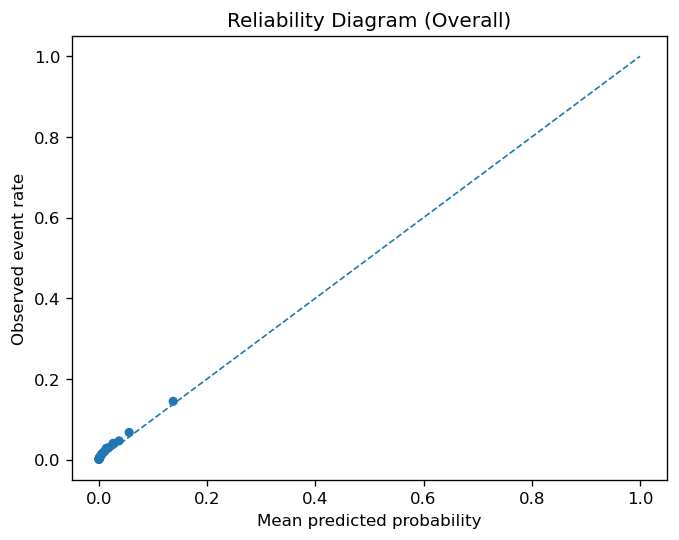

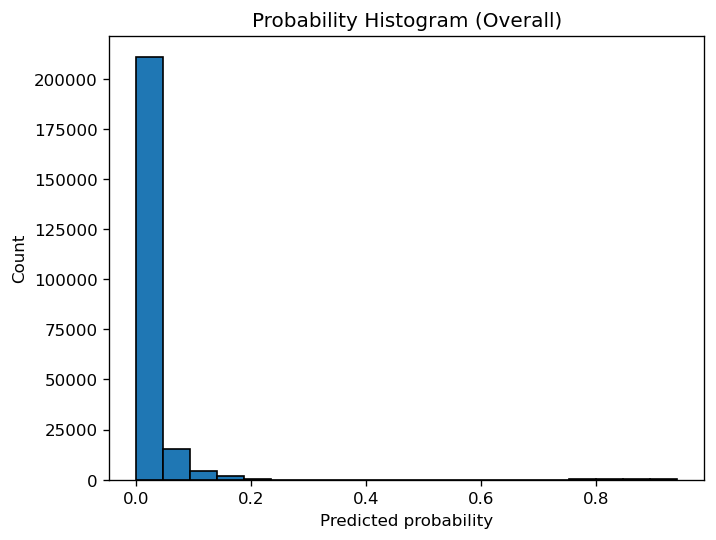

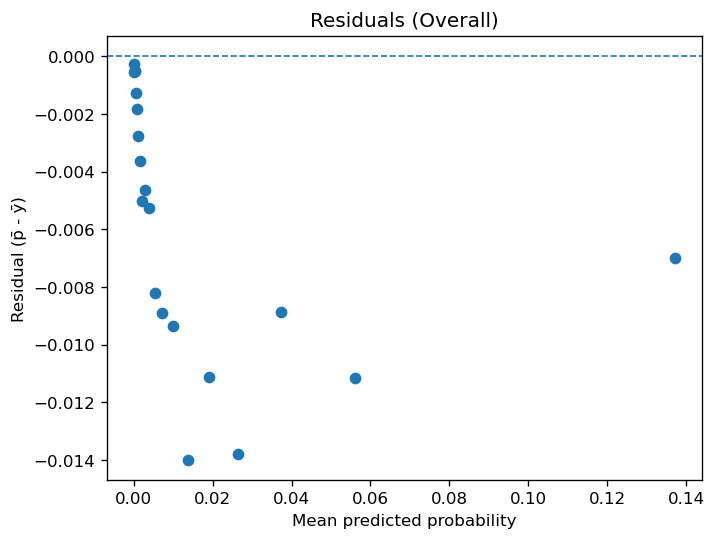

In [8]:
# ===== Cell 6: overall report =====
def overall_calibration_report(labels: np.ndarray, probs: np.ndarray, n_bins: int = 20, strategy: str = "quantile"):
    bins = summarize_bins(probs, labels, make_bins(probs, n_bins=n_bins, strategy=strategy))
    ece  = ece_from_bins(bins)
    mce  = mce_from_bins(bins)
    ace  = rmsce_from_bins(bins)
    bdec = brier_decomposition(labels, probs, bins)

    print("=== OVERALL CALIBRATION ===")
    print(f"Prevalence: {labels.mean():.6f}  |  Bins: {len(bins)} ({strategy})")
    print(f"ECE: {ece:.6f} | MCE: {mce:.6f} | ACE/RMSCE: {ace:.6f}")
    print(f"Brier: {bdec['brier']:.6f}  ->  Unc={bdec['uncertainty']:.6f}  Res={bdec['resolution']:.6f}  Rel={bdec['reliability']:.6f}")
    print(f"Check (Unc - Res + Rel): {bdec['check_sum']:.6f}")

    # plots
    plot_reliability(bins, f"Reliability Diagram (Overall)",
                     savepath=os.path.join(BASE_OUT, f"{BASE_NAME}_reliability_overall.png"))
    plot_prob_histogram(probs, n_bins, "Probability Histogram (Overall)",
                        savepath=os.path.join(BASE_OUT, f"{BASE_NAME}_hist_overall.png"))
    plot_residuals(bins, "Residuals (Overall)",
                   savepath=os.path.join(BASE_OUT, f"{BASE_NAME}_residuals_overall.png"))

    # save bins table
    bins_df = pd.DataFrame([{"n":b.n, "p_mean":b.p_mean, "y_rate":b.y_rate,
                             "abs_err":b.abs_err, "sq_err":b.sq_err} for b in bins])
    bins_df.to_csv(os.path.join(BASE_OUT, f"{BASE_NAME}_overall_bins.csv"), index=False)
    return {"ece": ece, "mce": mce, "ace": ace, "bdec": bdec, "bins_df": bins_df}

overall_stats = overall_calibration_report(y, p, n_bins=20, strategy="quantile")


[skip] race_standard='American Indian/Alaska Native' (n=546)


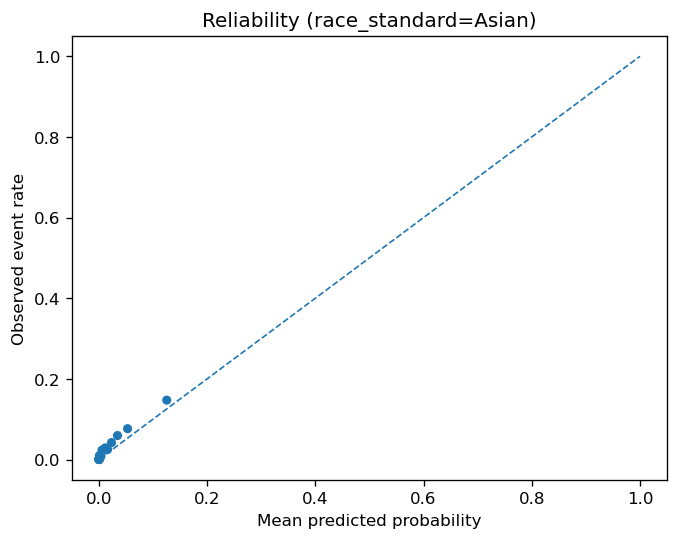

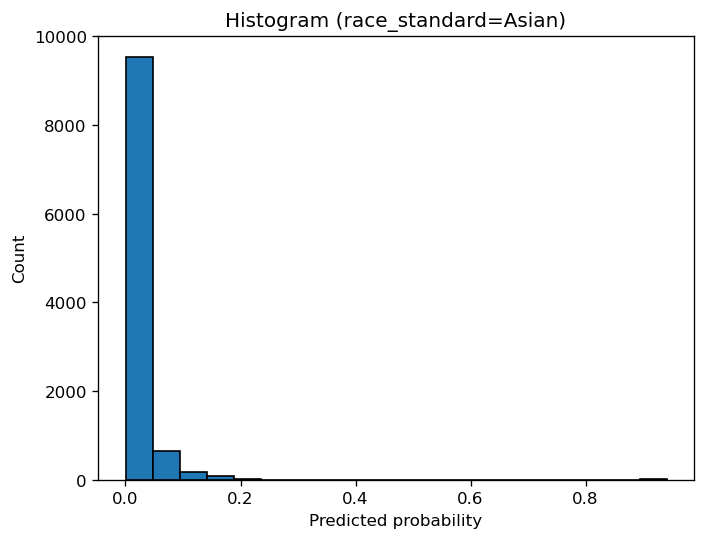

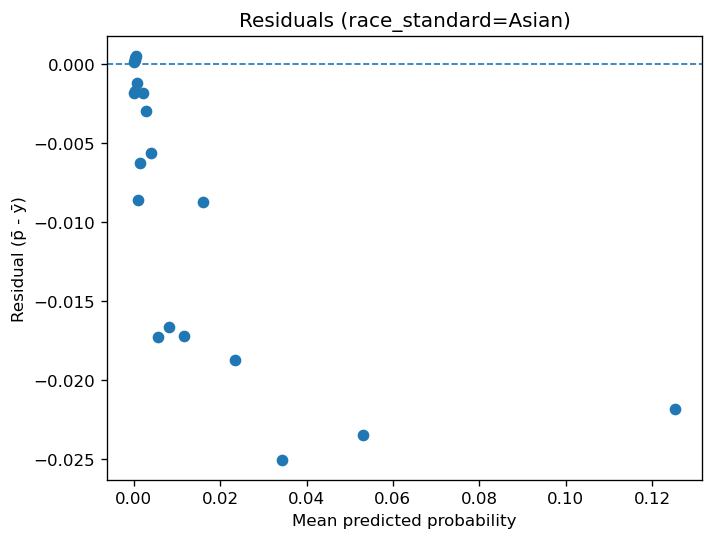

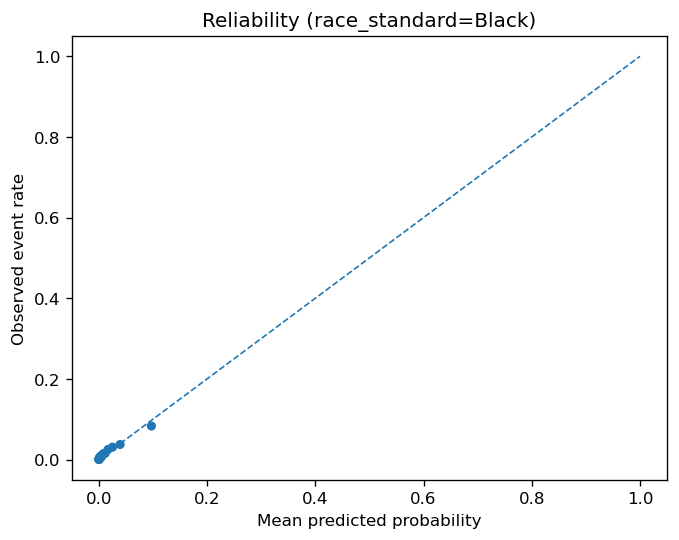

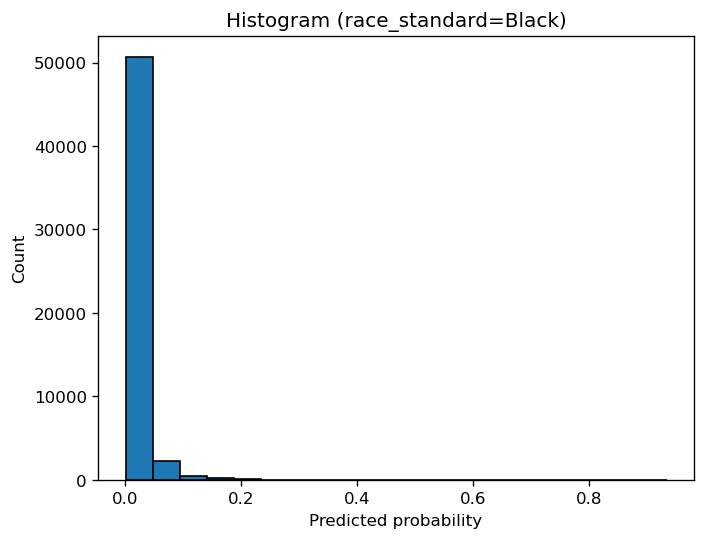

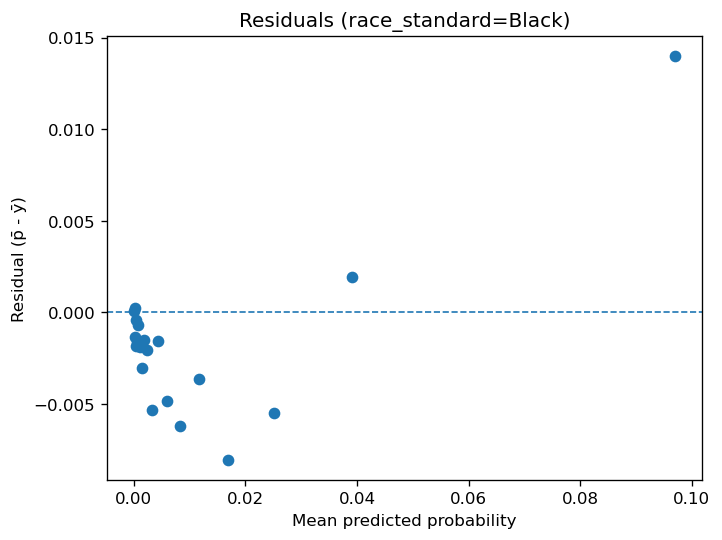

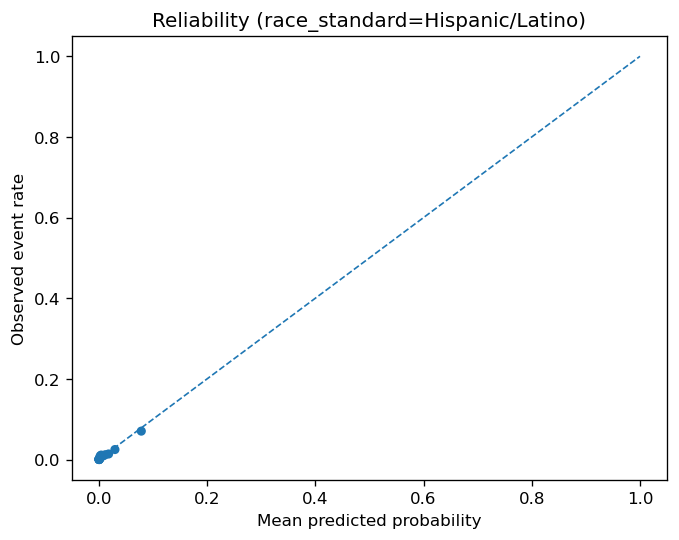

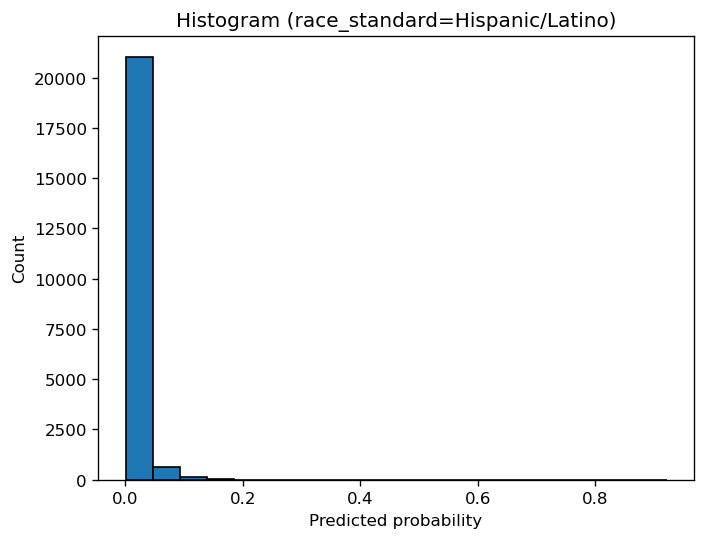

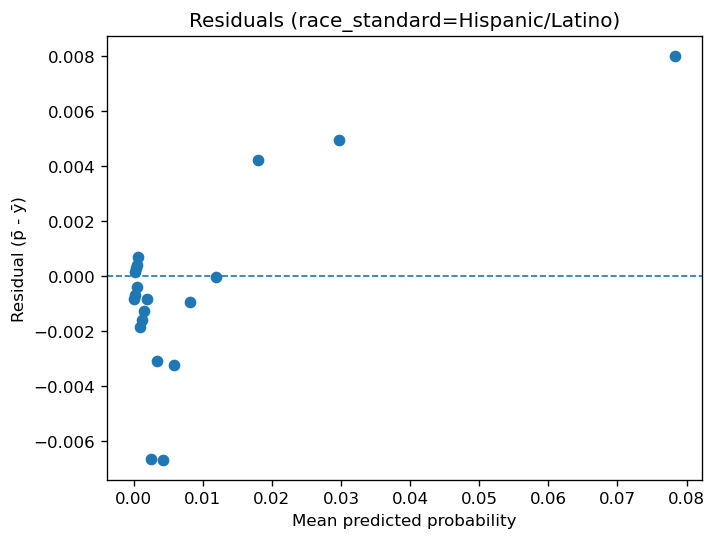

[skip] race_standard='Multiple Races' (n=90)
[skip] race_standard='Native Hawaiian/Pacific Islander' (n=285)


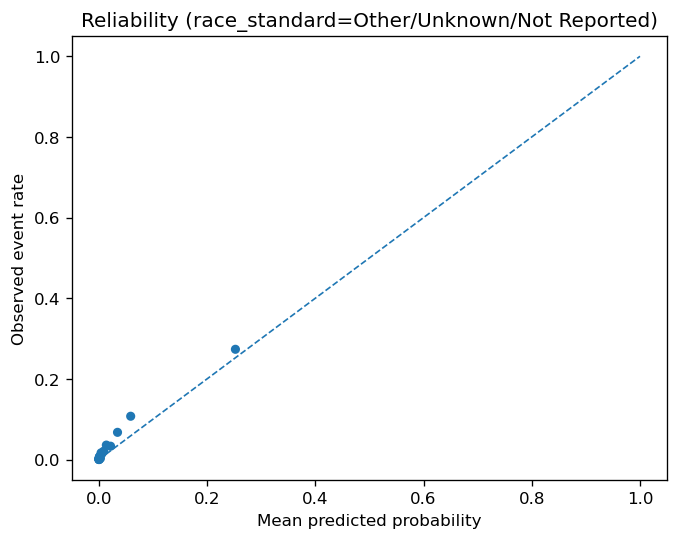

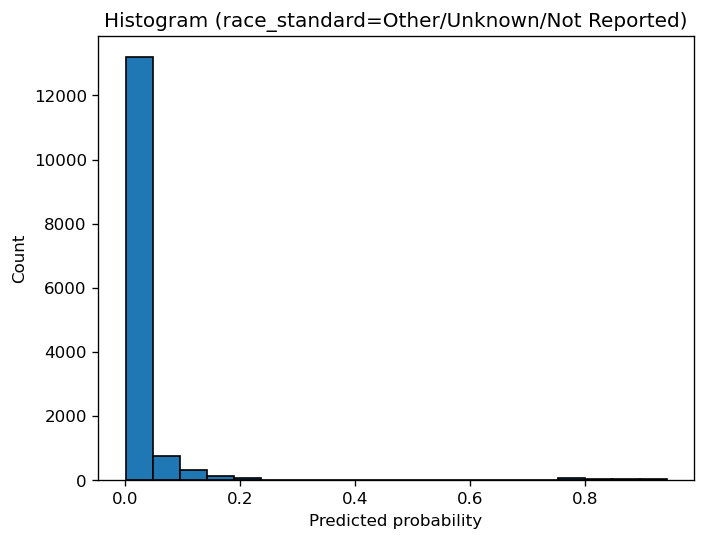

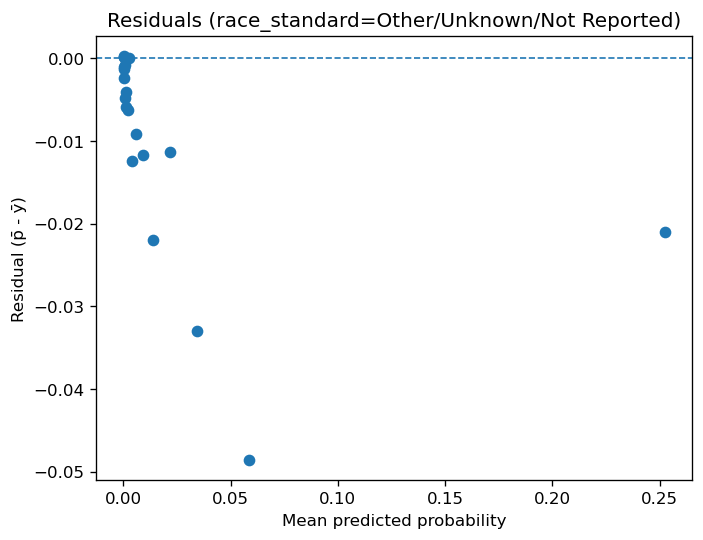

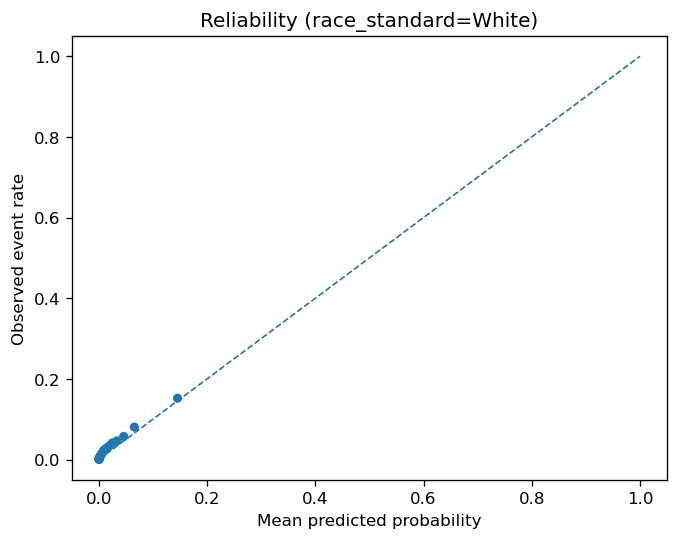

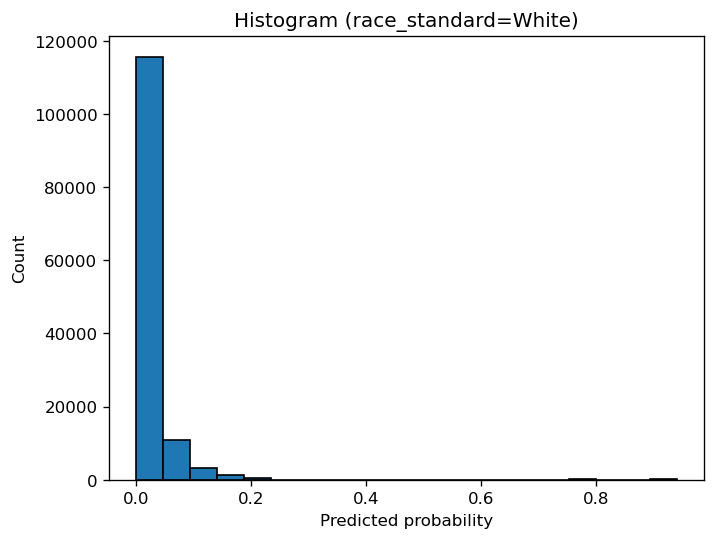

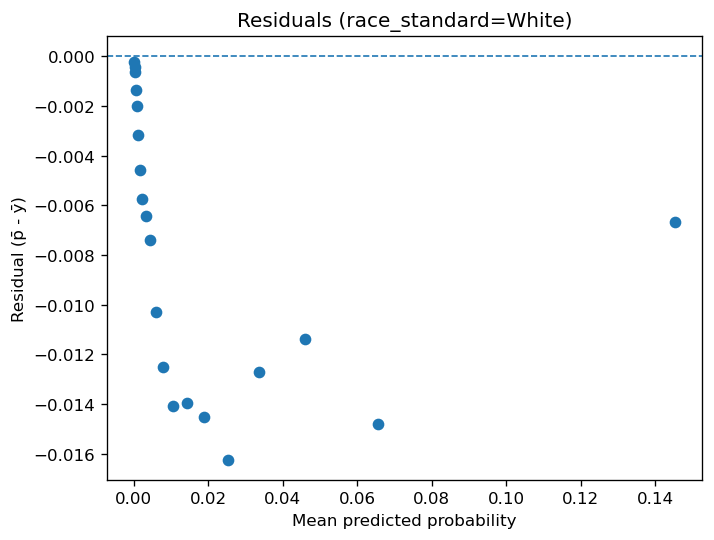

,race_standard,n,prevalence,ECE,MCE,ACE,Brier,Uncertainty,Resolution,Reliability
2,Hispanic/Latino,21868,0.008963,0.002343,0.007985,0.003363,0.008248,0.008883,0.000237,0.000011
1,Black,53687,0.012722,0.003281,0.013977,0.004623,0.011858,0.012560,0.000368,0.000021
4,White,131424,0.027316,0.007953,0.016229,0.009617,0.024780,0.026570,0.001267,0.000092
0,Asian,10453,0.023438,0.009011,0.025030,0.012484,0.021194,0.022889,0.001237,0.000156
3,Other/Unknown/Not Reported,14542,0.030257,0.009819,0.048532,0.015806,0.024663,0.029342,0.003802,0.000250


Saved group report: dataset/ed/finals/pics\16_finalwithsigmoid_report_race_standard.csv


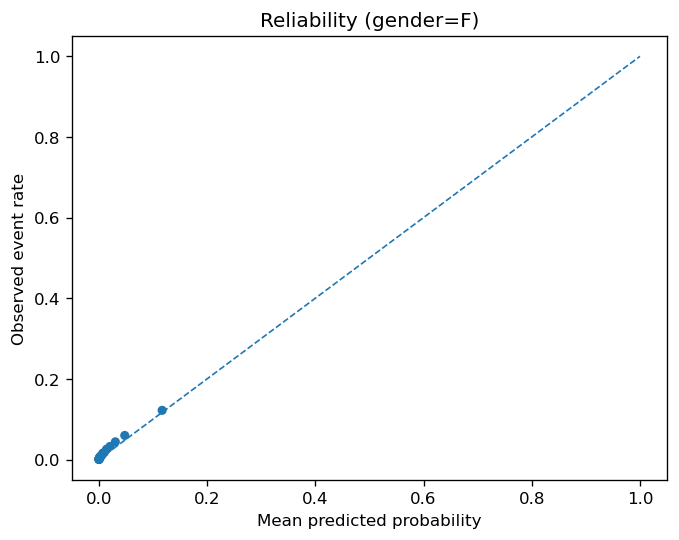

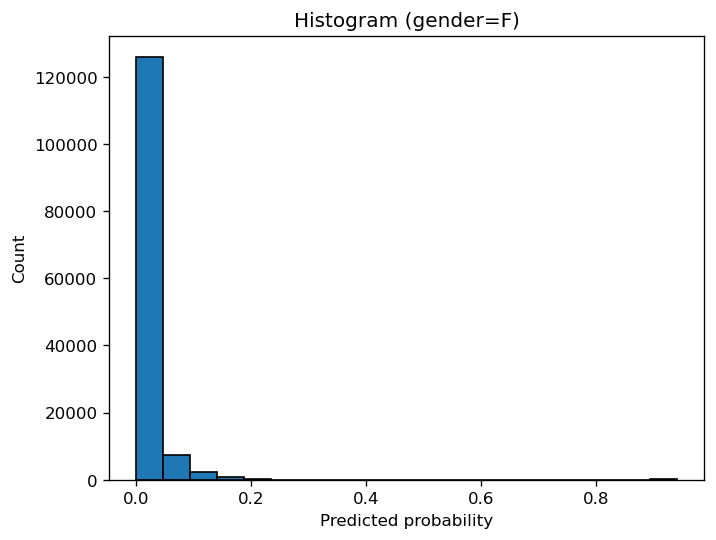

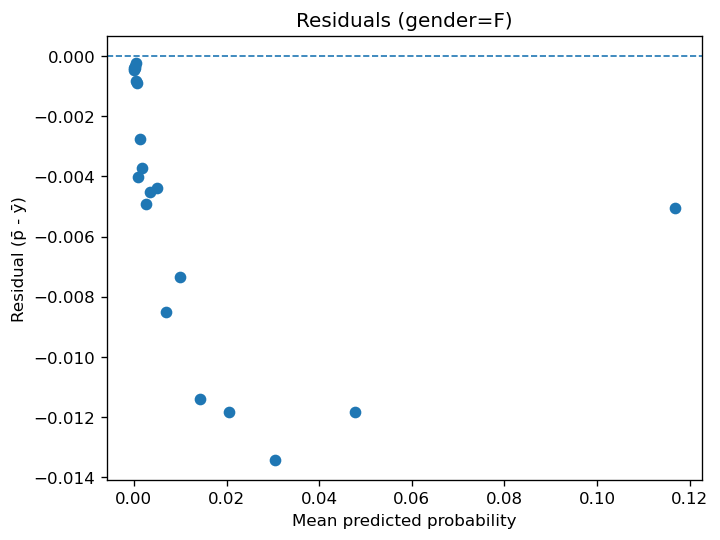

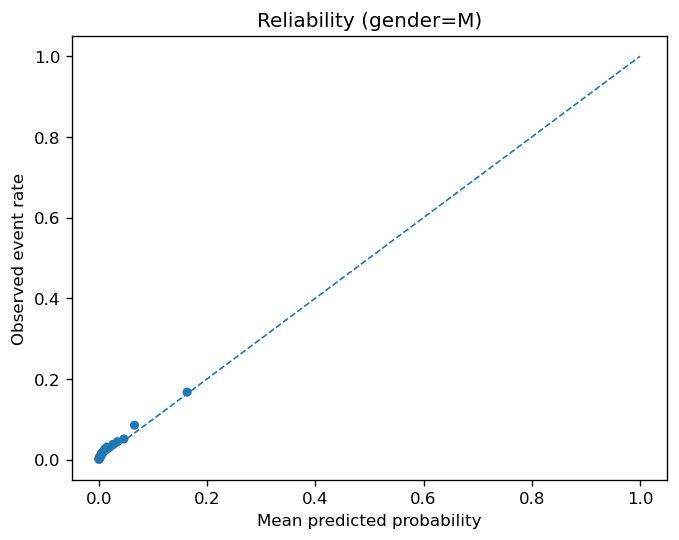

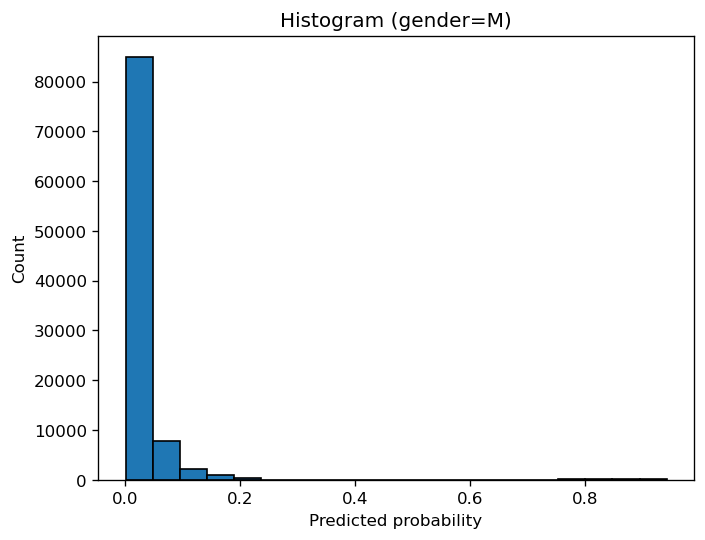

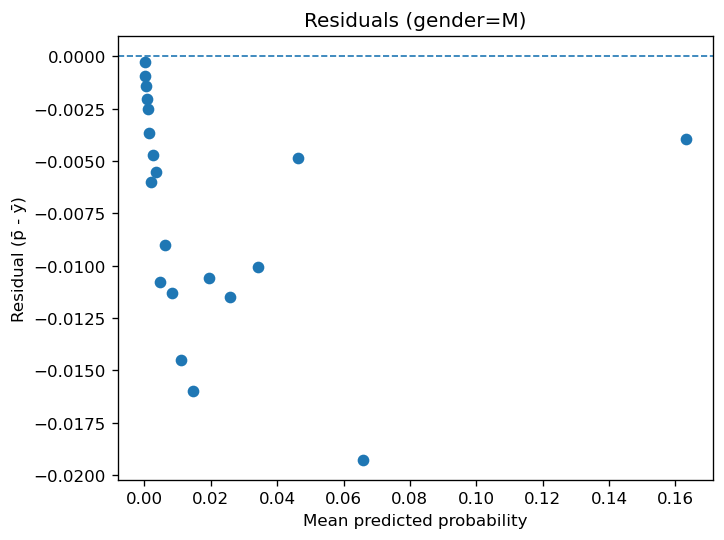

,gender,n,prevalence,ECE,MCE,ACE,Brier,Uncertainty,Resolution,Reliability
0,F,136433,0.018082,0.004864,0.013423,0.006505,0.016417,0.017755,0.000818,0.000042
1,M,96462,0.028052,0.007448,0.019250,0.009119,0.025197,0.027266,0.001449,0.000083


Saved group report: dataset/ed/finals/pics\16_finalwithsigmoid_report_gender.csv


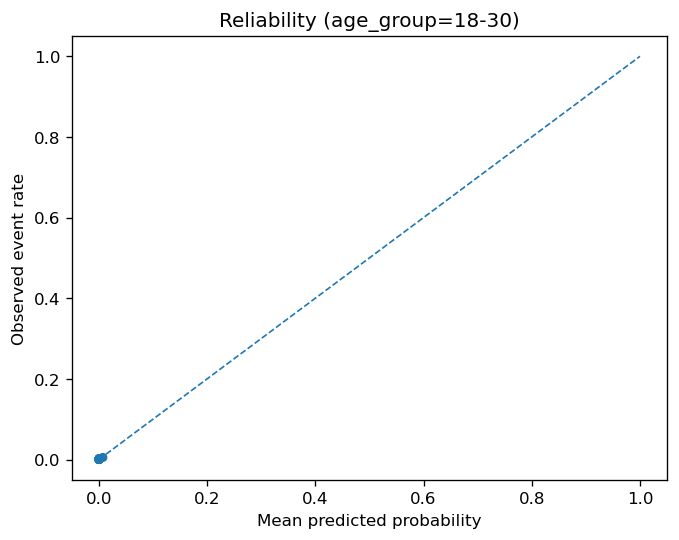

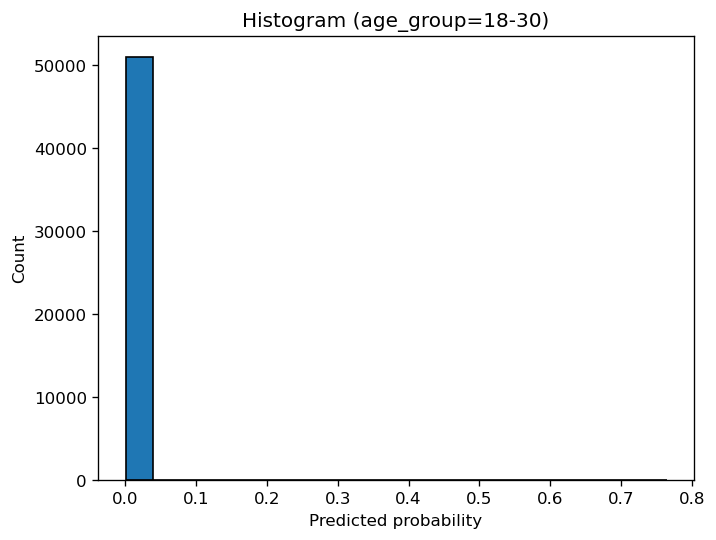

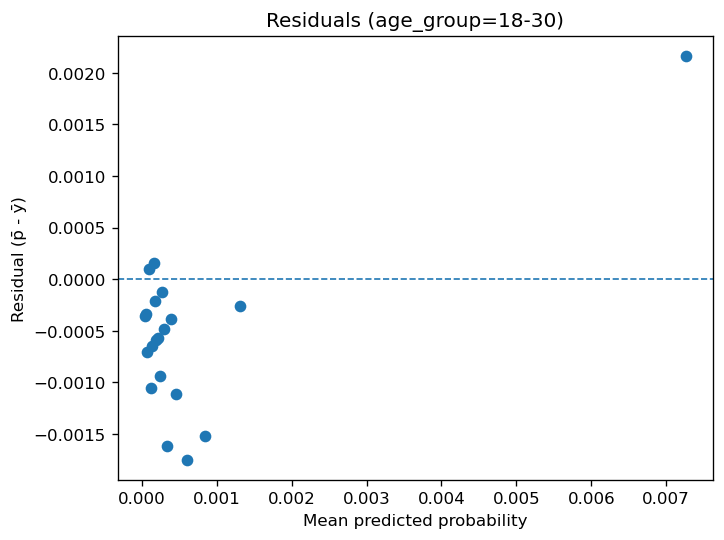

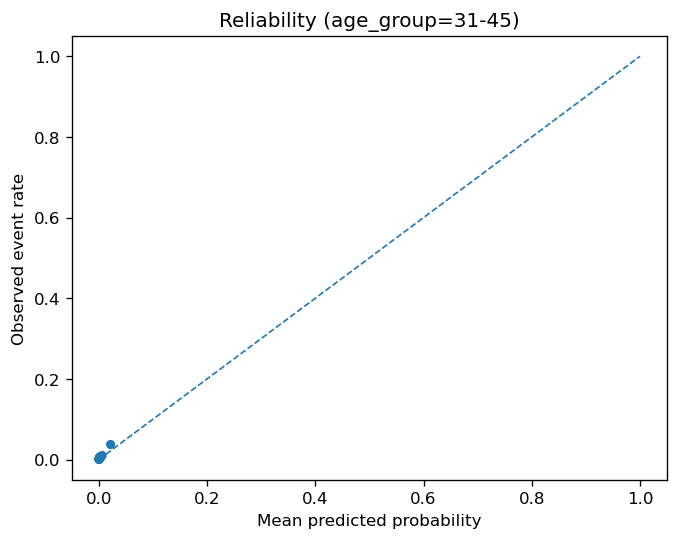

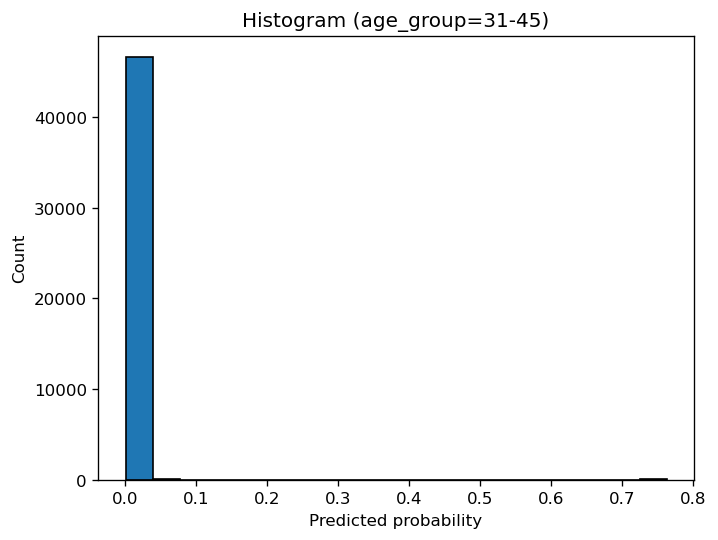

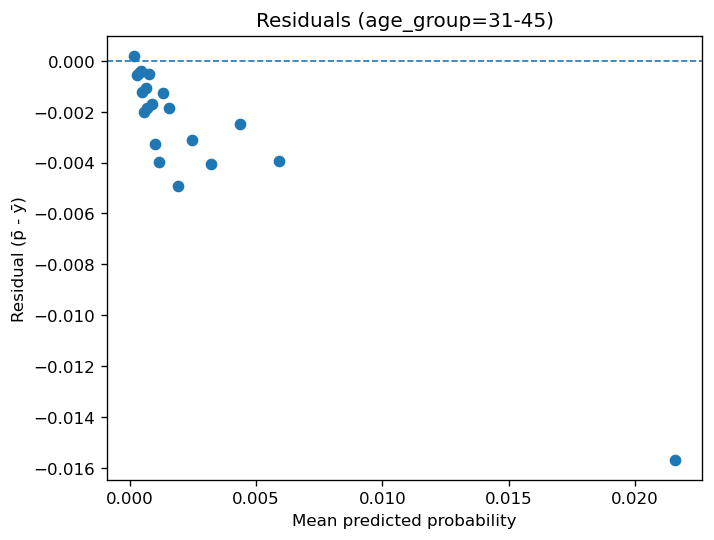

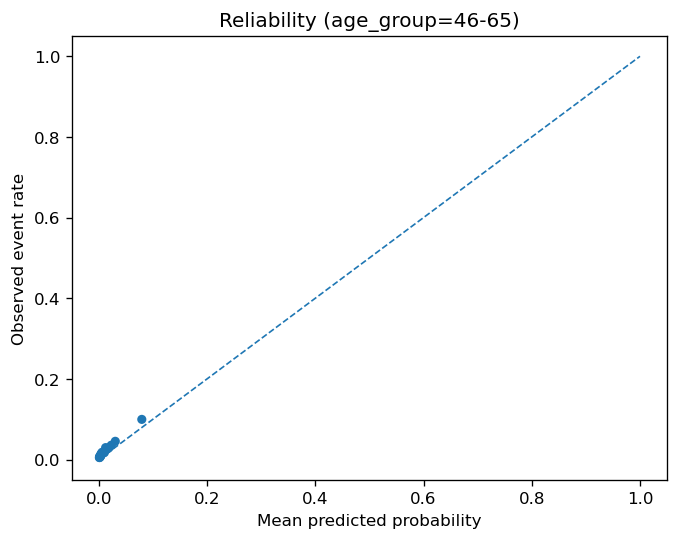

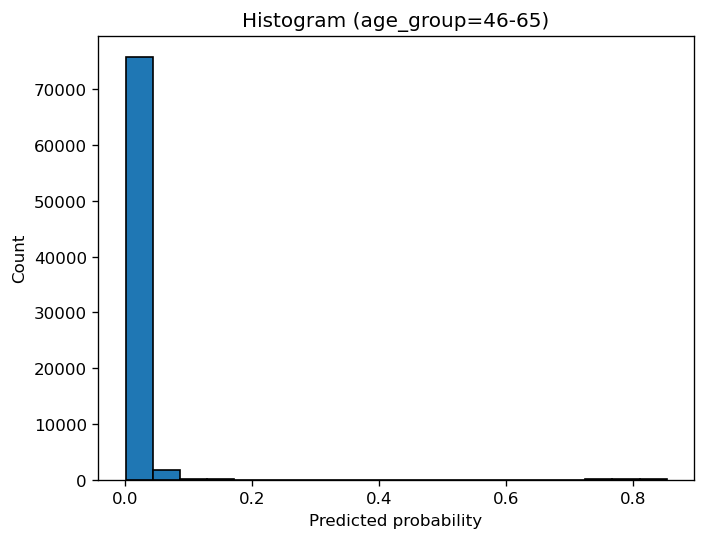

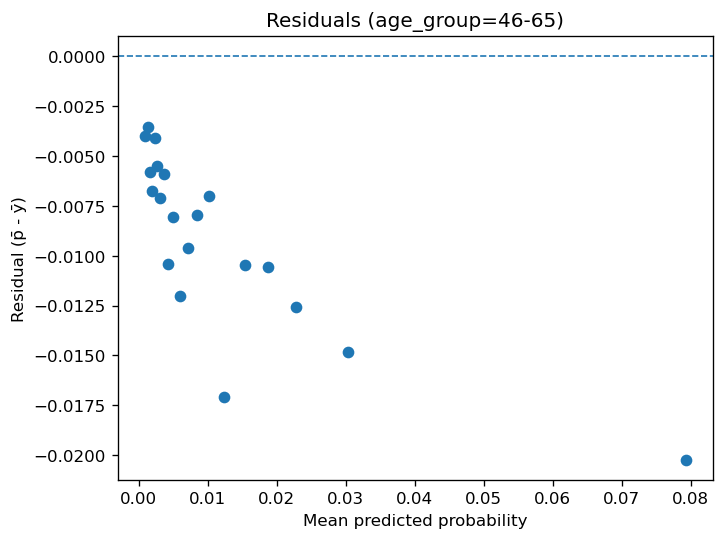

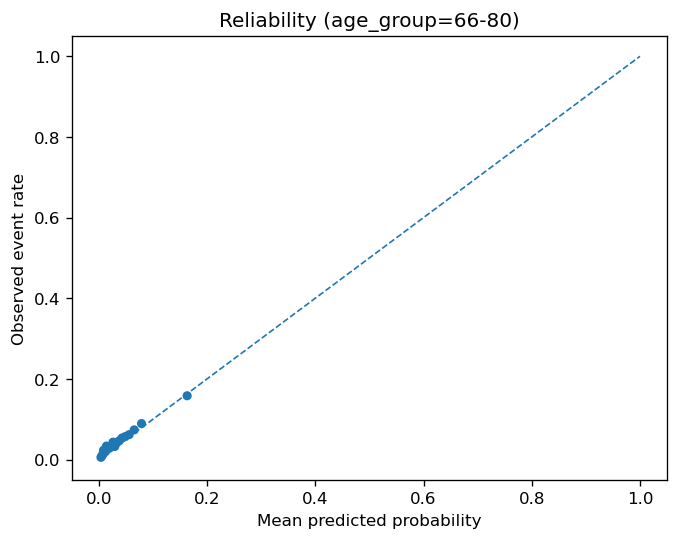

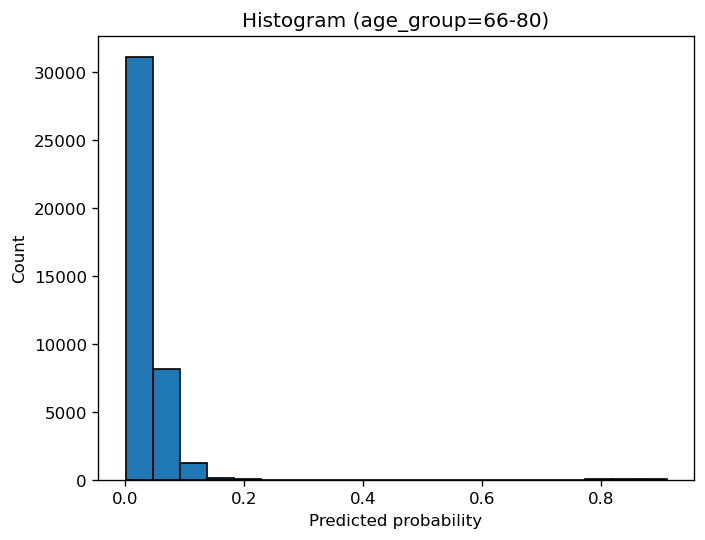

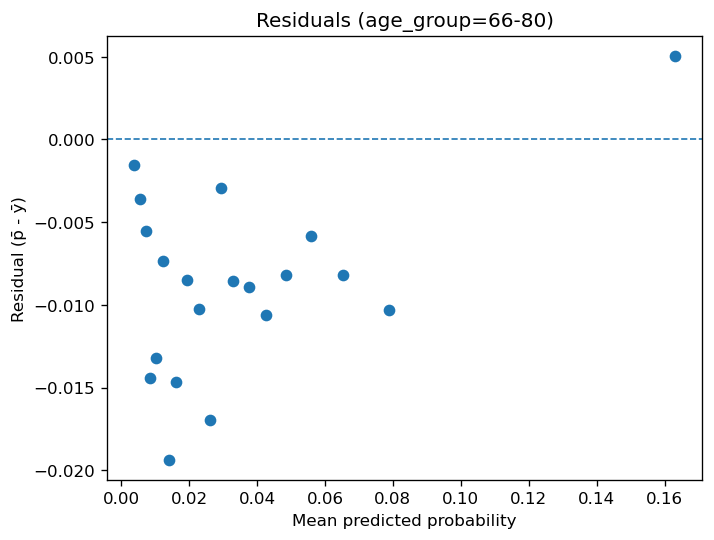

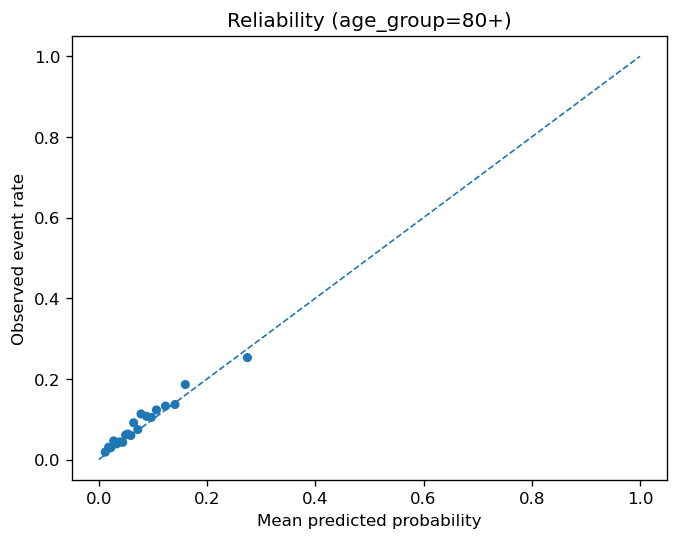

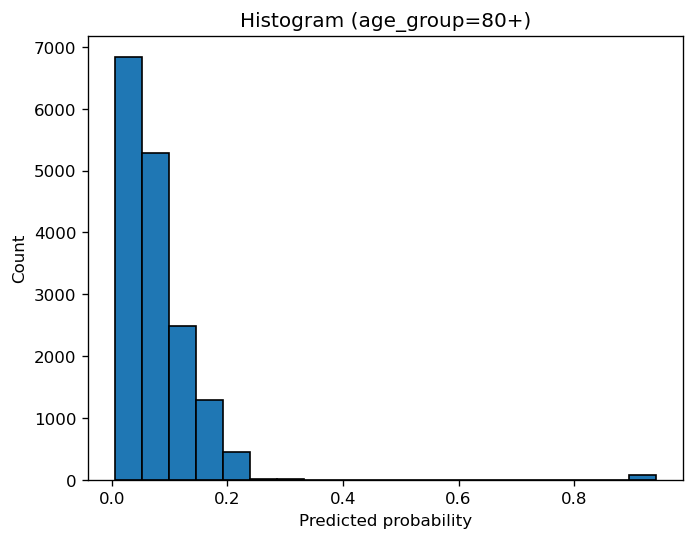

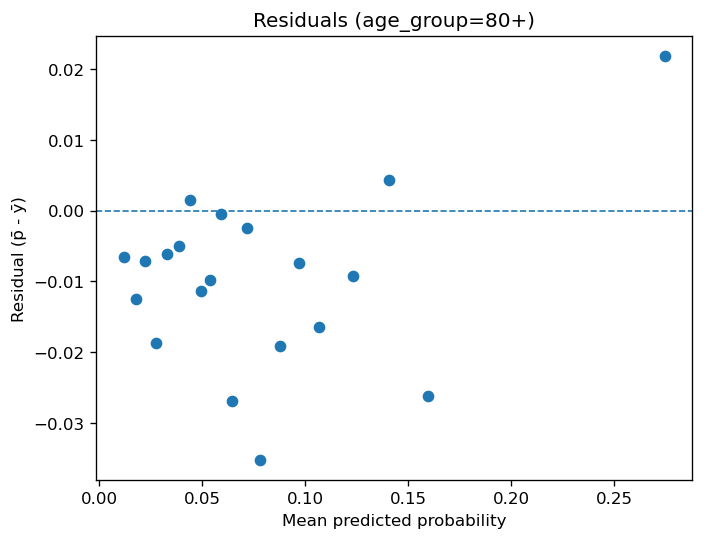

,age_group,n,prevalence,ECE,MCE,ACE,Brier,Uncertainty,Resolution,Reliability
0,18-30,50940,0.001178,0.000754,0.002159,0.000955,0.001204,0.001176,0.000001,9.126811e-07
1,31-45,46692,0.005204,0.002732,0.015677,0.004267,0.004937,0.005177,0.000061,1.820509e-05
2,46-65,77961,0.021049,0.009176,0.020217,0.010155,0.019561,0.020606,0.000438,1.031314e-04
3,66-80,40851,0.043744,0.009197,0.019354,0.010270,0.039661,0.041831,0.001121,1.054697e-04
4,80+,16451,0.087654,0.012402,0.035152,0.015506,0.074972,0.079971,0.003285,2.404301e-04


Saved group report: dataset/ed/finals/pics\16_finalwithsigmoid_report_age_group.csv


In [9]:
# ===== Cell 7: grouped calibration =====
def grouped_calibration(
    df: pd.DataFrame, prob_col: str, y_col: str, group_col: str,
    n_bins: int = 20, strategy: str = "quantile", min_n_group: int = 1000
):
    if group_col not in df.columns:
        print(f"[WARN] '{group_col}' not found; skipping.")
        return None

    rows = []
    for gval, sub in df.groupby(group_col):
        if len(sub) < min_n_group:
            print(f"[skip] {group_col}={gval!r} (n={len(sub)})")
            continue
        yy = _ensure_binary(sub[y_col]); pp = _safe_prob(sub[prob_col])
        bins = summarize_bins(pp, yy, make_bins(pp, n_bins=n_bins, strategy=strategy))
        ece = ece_from_bins(bins); mce = mce_from_bins(bins); ace = rmsce_from_bins(bins)
        bdec = brier_decomposition(yy, pp, bins)
        rows.append({
            group_col: gval, "n": len(sub), "prevalence": float(np.mean(yy)),
            "ECE": ece, "MCE": mce, "ACE": ace, "Brier": brier_score(yy, pp),
            "Uncertainty": bdec["uncertainty"], "Resolution": bdec["resolution"], "Reliability": bdec["reliability"]
        })
        # plots
        safe = str(gval).replace("/", "-")
        plot_reliability(bins, f"Reliability ({group_col}={gval})",
                         savepath=os.path.join(BASE_OUT, f"{BASE_NAME}_reliability_{group_col}={safe}.png"))
        plot_prob_histogram(pp, n_bins, f"Histogram ({group_col}={gval})",
                            savepath=os.path.join(BASE_OUT, f"{BASE_NAME}_hist_{group_col}={safe}.png"))
        plot_residuals(bins, f"Residuals ({group_col}={gval})",
                       savepath=os.path.join(BASE_OUT, f"{BASE_NAME}_resid_{group_col}={safe}.png"))

    if not rows:
        print("[INFO] No groups met min_n_group.")
        return None
    rep = pd.DataFrame(rows).sort_values("ECE")
    display(rep)
    # save
    rep.to_csv(os.path.join(BASE_OUT, f"{BASE_NAME}_report_{group_col}.csv"), index=False)
    print(f"Saved group report: {os.path.join(BASE_OUT, f'{BASE_NAME}_report_{group_col}.csv')}")
    return rep

rep_race   = grouped_calibration(df_clean, "mortality_prob", "died_within_30_days", "race_standard", n_bins=20)
rep_gender = grouped_calibration(df_clean, "mortality_prob", "died_within_30_days", "gender", n_bins=20)
rep_age    = grouped_calibration(df_clean, "mortality_prob", "died_within_30_days", "age_group", n_bins=20)


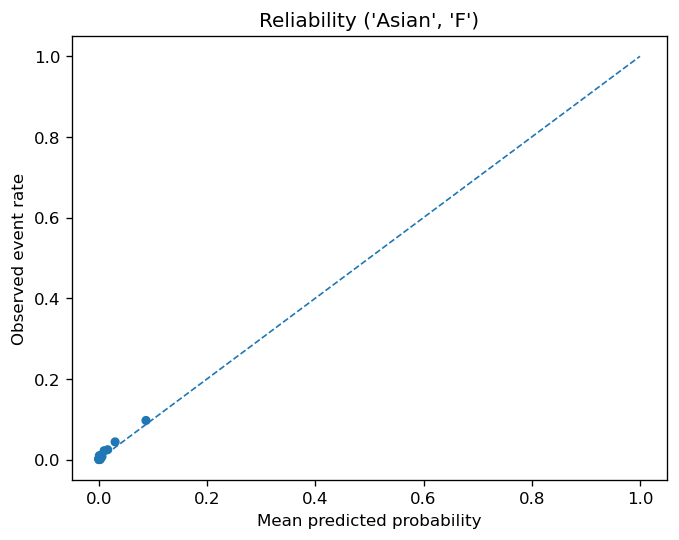

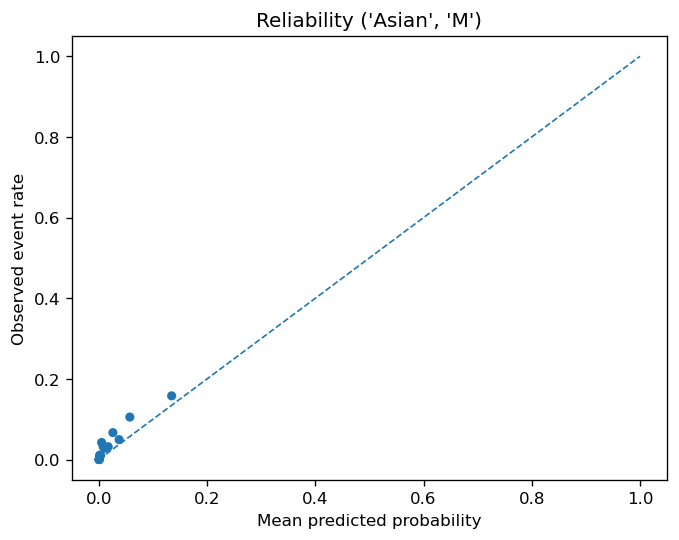

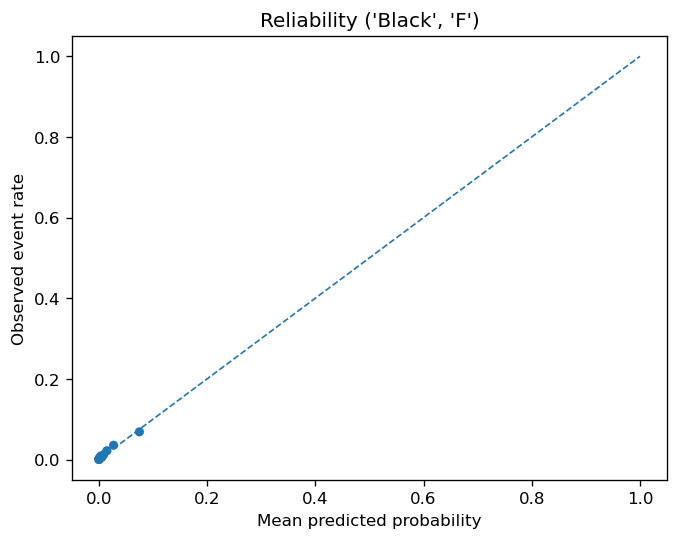

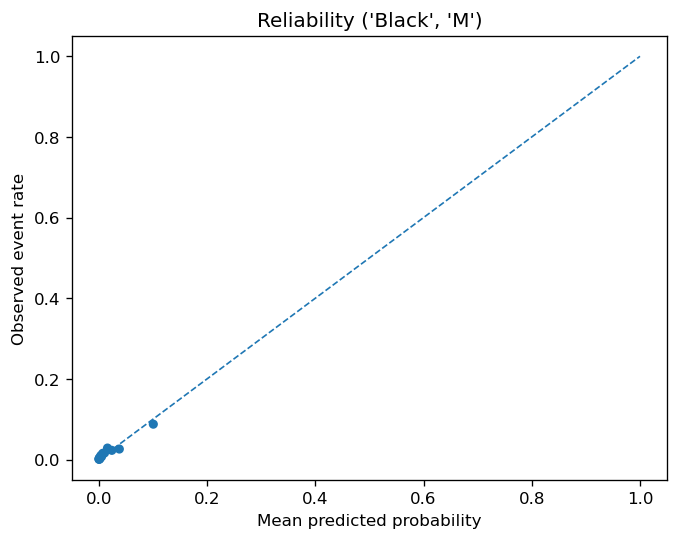

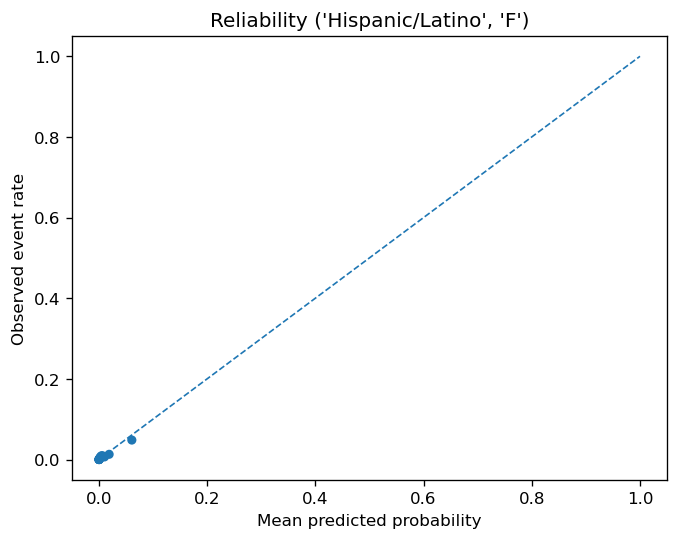

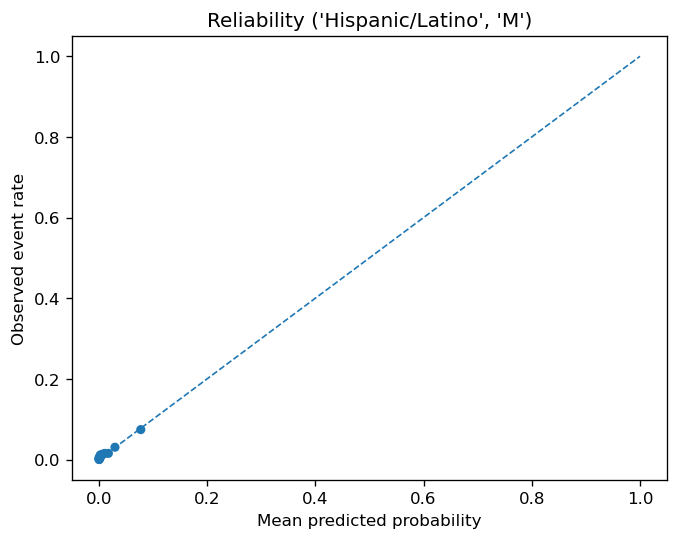

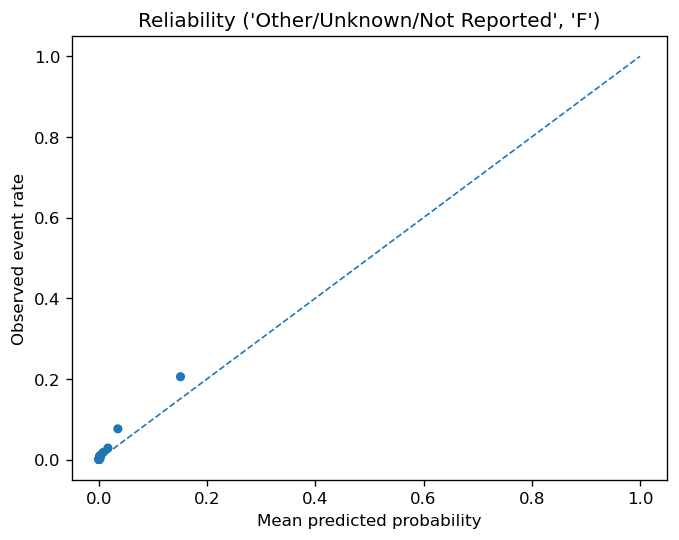

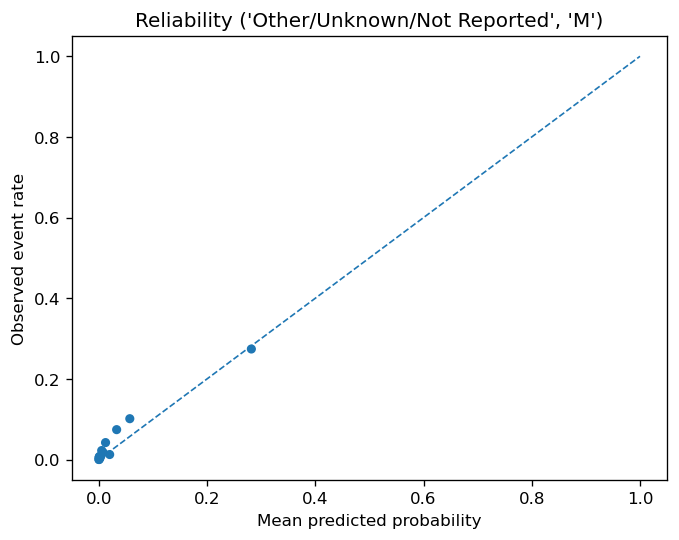

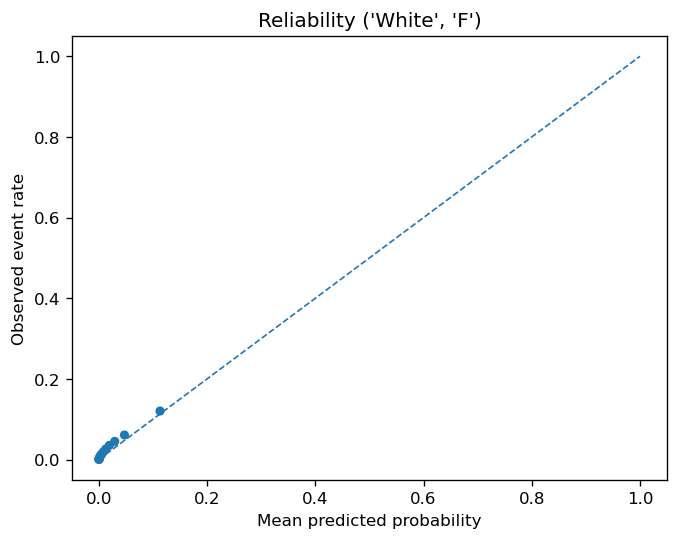

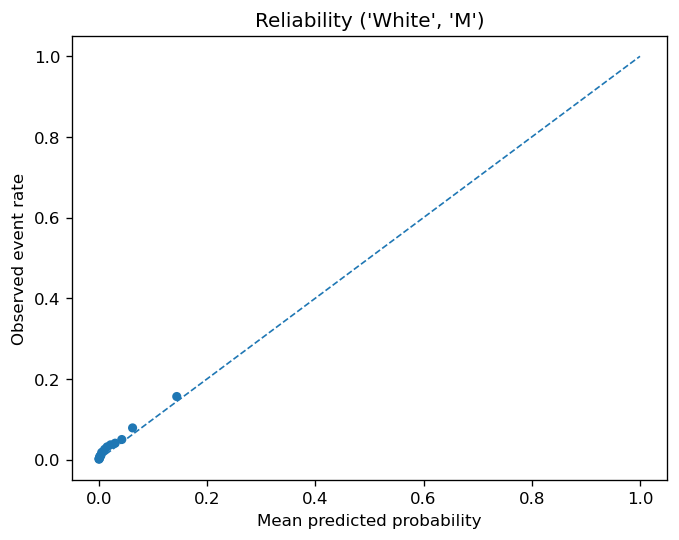

,group,n,prev,ECE,MCE,ACE,Brier
4,"(Hispanic/Latino, F)",13985,0.006578,0.002584,0.012666,0.004167,0.006038
2,"(Black, F)",35195,0.011365,0.002802,0.008229,0.003797,0.010795
5,"(Hispanic/Latino, M)",7883,0.013193,0.003394,0.008716,0.004107,0.012168
0,"(Asian, F)",6184,0.014554,0.004532,0.013705,0.006373,0.013130
3,"(Black, M)",18492,0.015304,0.004649,0.012993,0.006475,0.013882
8,"(White, F)",72092,0.023234,0.006999,0.015840,0.008906,0.021047
9,"(White, M)",59332,0.032276,0.009111,0.016134,0.010514,0.029317
6,"(Other/Unknown/Not Reported, F)",8469,0.024324,0.009646,0.054448,0.018346,0.020563
7,"(Other/Unknown/Not Reported, M)",6073,0.038531,0.012189,0.044105,0.018531,0.030380
1,"(Asian, M)",4269,0.036308,0.016159,0.048070,0.022050,0.032876


Saved intersection report: dataset/ed/finals/pics\16_finalwithsigmoid_report_intersection_race_standardxgender.csv


In [10]:
# ===== Cell 8: intersectional calibration =====
def intersectional_calibration(
    df: pd.DataFrame, prob_col: str, y_col: str, group_cols: List[str],
    n_bins: int = 15, strategy: str = "quantile", min_n_cell: int = 800
):
    for c in group_cols:
        if c not in df.columns:
            print(f"[WARN] '{c}' missing; aborting intersections.")
            return None
    df = df.copy()
    df["_ix_"] = list(zip(*[df[c].astype(str).fillna("NA") for c in group_cols]))

    rows = []
    for key, sub in df.groupby("_ix_"):
        if len(sub) < min_n_cell:
            continue
        yy = _ensure_binary(sub[y_col]); pp = _safe_prob(sub[prob_col])
        bins = summarize_bins(pp, yy, make_bins(pp, n_bins=n_bins, strategy=strategy))
        rows.append({
            "group": key, "n": len(sub), "prev": float(np.mean(yy)),
            "ECE": ece_from_bins(bins), "MCE": mce_from_bins(bins),
            "ACE": rmsce_from_bins(bins), "Brier": brier_score(yy, pp)
        })
        safe_key = "__".join(map(str, key)).replace("/", "-")
        plot_reliability(bins, f"Reliability {key}",
                         savepath=os.path.join(BASE_OUT, f"{BASE_NAME}_reliability_ix_{safe_key}.png"))
    if not rows:
        print("[INFO] No intersection cells met min_n_cell.")
        return None
    rep = pd.DataFrame(rows).sort_values("ECE")
    display(rep.head(20))
    out_csv = os.path.join(BASE_OUT, f"{BASE_NAME}_report_intersection_{'x'.join(group_cols)}.csv")
    rep.to_csv(out_csv, index=False)
    print(f"Saved intersection report: {out_csv}")
    return rep

rep_ix = intersectional_calibration(df_clean, "mortality_prob", "died_within_30_days",
                                    group_cols=["race_standard","gender"], n_bins=15)


In [11]:
# ===== Cell 9 (fixed & robust): slope & intercept =====
from sklearn.linear_model import LogisticRegression

def calibration_slope_intercept(y, p):
    z = _safe_logit(p)
    X = z.reshape(-1, 1)
    try:
        # Newer sklearn: supports penalty=None with lbfgs
        lr = LogisticRegression(penalty=None, solver="lbfgs", max_iter=1000)
        lr.fit(X, y)
    except Exception:
        # Fallback for older sklearn: use very weak L2 to approximate "no penalty"
        lr = LogisticRegression(penalty="l2", C=1e9, solver="lbfgs", max_iter=1000)
        lr.fit(X, y)
    return float(lr.intercept_[0]), float(lr.coef_[0, 0])

intercept, slope = calibration_slope_intercept(y, p)
print(f"Calibration intercept: {intercept:+.4f}   slope: {slope:.4f}   (ideal: +0.0000, 1.0000)")


Calibration intercept: -0.4142   slope: 0.7640   (ideal: +0.0000, 1.0000)


In [12]:
# ===== Cell 10: consolidated CSV =====
# (Re-use bins from overall)
bins_overall = summarize_bins(p, y, make_bins(p, n_bins=20, strategy="quantile"))
bdec = brier_decomposition(y, p, bins_overall)
ece  = ece_from_bins(bins_overall); mce = mce_from_bins(bins_overall); ace = rmsce_from_bins(bins_overall)

records = [{
    "section": "overall",
    "group_type": None, "group_value": None,
    "n": int(len(y)), "prevalence": float(np.mean(y)),
    "ECE": ece, "MCE": mce, "ACE": ace, "Brier": brier_score(y, p),
    "Uncertainty": bdec["uncertainty"], "Resolution": bdec["resolution"], "Reliability": bdec["reliability"],
    "Intercept": intercept, "Slope": slope
}]

def _append(rep_df, group_col):
    if rep_df is None or rep_df.empty: return
    for _, r in rep_df.iterrows():
        records.append({
            "section": "group",
            "group_type": group_col, "group_value": r[group_col],
            "n": int(r["n"]), "prevalence": float(r["prevalence"]),
            "ECE": float(r["ECE"]), "MCE": float(r["MCE"]), "ACE": float(r["ACE"]), "Brier": float(r["Brier"]),
            "Uncertainty": float(r["Uncertainty"]), "Resolution": float(r["Resolution"]), "Reliability": float(r["Reliability"]),
            "Intercept": None, "Slope": None
        })

_append(rep_race, "race_standard")
_append(rep_gender, "gender")
_append(rep_age, "age_group")

if rep_ix is not None and not rep_ix.empty:
    for _, r in rep_ix.iterrows():
        records.append({
            "section": "intersection",
            "group_type": "race_standard×gender", "group_value": str(r["group"]),
            "n": int(r["n"]), "prevalence": float(r["prev"]),
            "ECE": float(r["ECE"]), "MCE": float(r["MCE"]), "ACE": float(r["ACE"]), "Brier": float(r["Brier"]),
            "Uncertainty": None, "Resolution": None, "Reliability": None,
            "Intercept": None, "Slope": None
        })

CONSOLIDATED_CSV = os.path.join(BASE_OUT, f"{BASE_NAME}.csv")
pd.DataFrame(records).to_csv(CONSOLIDATED_CSV, index=False)
print(f"Saved consolidated metrics to: {CONSOLIDATED_CSV}")


Saved consolidated metrics to: dataset/ed/finals/pics\16_finalwithsigmoid.csv


In [42]:
# Signed calibration error: weighted mean of (p̄ - ȳ) across bins
def signed_cal_error(labels, probs, n_bins=20, strategy="quantile"):
    bins = summarize_bins(probs, labels, make_bins(probs, n_bins=n_bins, strategy=strategy))
    N = sum(b.n for b in bins)
    return float(sum((b.n / N) * (b.p_mean - b.y_rate) for b in bins))

def signed_error_by_group(df, prob_col, y_col, group_cols=("race_standard","gender"),
                          n_bins=20, strategy="quantile", min_n=800):
    out = []
    g = df.copy()
    g["_ix_"] = list(zip(*[g[c].astype(str).fillna("NA") for c in group_cols]))
    for key, sub in g.groupby("_ix_"):
        if len(sub) < min_n: 
            continue
        yy = _ensure_binary(sub[y_col]); pp = _safe_prob(sub[prob_col])
        sce = signed_cal_error(yy, pp, n_bins=n_bins, strategy=strategy)
        out.append({"group": key, "n": len(sub), "signed_err": sce})
    rep = pd.DataFrame(out).sort_values("signed_err")
    display(rep)
    rep.to_csv(os.path.join(BASE_OUT, f"{BASE_NAME}_signed_error_{'x'.join(group_cols)}.csv"), index=False)
    print("Saved signed-error report.")
    return rep

signed_ix = signed_error_by_group(df_clean, "mortality_prob", "died_within_30_days",
                                  group_cols=("race_standard","gender"), n_bins=20)


,group,n,signed_err
1,"(Asian, M)",4269,-0.015959
7,"(Other/Unknown/Not Reported, M)",6073,-0.010100
6,"(Other/Unknown/Not Reported, F)",8469,-0.009522
9,"(White, M)",59332,-0.009111
8,"(White, F)",72092,-0.006999
0,"(Asian, F)",6184,-0.004013
5,"(Hispanic/Latino, M)",7883,-0.002520
2,"(Black, F)",35195,-0.001925
3,"(Black, M)",18492,-0.001165
4,"(Hispanic/Latino, F)",13985,0.000678


Saved signed-error report.


In [44]:
def slope_intercept_by_group(df, prob_col, y_col, group_cols=("race_standard","gender"),
                             min_n=800):
    rows=[]
    g = df.copy()
    g["_ix_"] = list(zip(*[g[c].astype(str).fillna("NA") for c in group_cols]))
    for key, sub in g.groupby("_ix_"):
        if len(sub) < min_n:
            continue
        yy = _ensure_binary(sub[y_col]); pp = _safe_prob(sub[prob_col])
        z  = _safe_logit(pp).reshape(-1,1)
        # robust to sklearn version
        try:
            lr = LogisticRegression(penalty=None, solver="lbfgs", max_iter=1000)
            lr.fit(z, yy)
        except Exception:
            lr = LogisticRegression(penalty="l2", C=1e9, solver="lbfgs", max_iter=1000)
            lr.fit(z, yy)
        rows.append({"group": key, "n": len(sub),
                     "intercept": float(lr.intercept_[0]),
                     "slope": float(lr.coef_[0,0])})
    rep = pd.DataFrame(rows).sort_values("slope")
    display(rep)
    rep.to_csv(os.path.join(BASE_OUT, f"{BASE_NAME}_slope_intercept_{'x'.join(group_cols)}.csv"), index=False)
    print("Saved slope/intercept report.")
    return rep

sl_ix = slope_intercept_by_group(df_clean, "mortality_prob", "died_within_30_days",
                                 group_cols=("race_standard","gender"))


,group,n,intercept,slope
1,"(Asian, M)",4269,-0.311897,0.695592
7,"(Other/Unknown/Not Reported, M)",6073,-0.307342,0.716980
5,"(Hispanic/Latino, M)",7883,-0.806377,0.722532
9,"(White, M)",59332,-0.481365,0.723515
2,"(Black, F)",35195,-0.703790,0.753157
8,"(White, F)",72092,-0.398177,0.756063
3,"(Black, M)",18492,-0.725339,0.763657
0,"(Asian, F)",6184,-0.415746,0.778873
6,"(Other/Unknown/Not Reported, F)",8469,0.030727,0.795277
4,"(Hispanic/Latino, F)",13985,-0.622833,0.863788


Saved slope/intercept report.


In [46]:
def bin_details_for_group(df, prob_col, y_col, group_tuple, group_cols=("race_standard","gender"),
                          n_bins=20, strategy="quantile"):
    g = df.copy()
    g["_ix_"] = list(zip(*[g[c].astype(str).fillna("NA") for c in group_cols]))
    sub = g[g["_ix_"] == group_tuple]
    yy = _ensure_binary(sub[y_col]); pp = _safe_prob(sub[prob_col])
    bins = summarize_bins(pp, yy, make_bins(pp, n_bins=n_bins, strategy=strategy))
    out = pd.DataFrame([{
        "n": b.n,
        "p_mean": b.p_mean,
        "y_rate": b.y_rate,
        "residual": b.p_mean - b.y_rate,  # sign shows over/under in that range
        "abs_err": b.abs_err
    } for b in bins]).sort_values("abs_err", ascending=False)
    display(out.head(10))
    return out

# Examples:
_ = bin_details_for_group(df_clean, "mortality_prob", "died_within_30_days", ("Asian","M"))
_ = bin_details_for_group(df_clean, "mortality_prob", "died_within_30_days", ("Other/Unknown/Not Reported","F"))


,n,p_mean,y_rate,residual,abs_err
18,213,0.068422,0.122066,-0.053643,0.053643
15,214,0.027255,0.074766,-0.047512,0.047512
10,213,0.006107,0.037559,-0.031452,0.031452
9,213,0.004245,0.032864,-0.028619,0.028619
17,214,0.048254,0.074766,-0.026512,0.026512
11,214,0.008416,0.032710,-0.024295,0.024295
12,213,0.011168,0.032864,-0.021696,0.021696
16,213,0.035429,0.056338,-0.020909,0.020909
14,213,0.019867,0.037559,-0.017691,0.017691
6,214,0.001633,0.014019,-0.012386,0.012386


,n,p_mean,y_rate,residual,abs_err
19,424,0.181843,0.242925,-0.061081,0.061081
18,423,0.047199,0.082742,-0.035543,0.035543
17,424,0.025913,0.056604,-0.030691,0.030691
16,423,0.015046,0.030733,-0.015687,0.015687
15,424,0.008691,0.021226,-0.012535,0.012535
11,424,0.001626,0.011792,-0.010167,0.010167
14,423,0.005333,0.014184,-0.008851,0.008851
10,423,0.001157,0.007092,-0.005936,0.005936
9,423,0.000843,0.004728,-0.003885,0.003885
13,424,0.003496,0.007075,-0.003579,0.003579


In [48]:
def top_problem_bins_all(df, group_cols=("race_standard","gender"),
                         prob_col="mortality_prob", y_col="died_within_30_days",
                         n_bins=20, top_k=5, min_n=800, strategy="quantile"):
    rows=[]
    g = df.copy()
    g["_ix_"] = list(zip(*[g[c].astype(str).fillna("NA") for c in group_cols]))
    for key, sub in g.groupby("_ix_"):
        if len(sub) < min_n:
            continue
        yy = _ensure_binary(sub[y_col]); pp = _safe_prob(sub[prob_col])
        bins = summarize_bins(pp, yy, make_bins(pp, n_bins=n_bins, strategy=strategy))
        # Sort by absolute error descending
        bd = sorted(bins, key=lambda b: b.abs_err, reverse=True)[:top_k]
        for rank, b in enumerate(bd, 1):
            rows.append({
                "group": key, "rank": rank, "n_in_bin": b.n,
                "p_mean": b.p_mean, "y_rate": b.y_rate,
                "residual": b.p_mean - b.y_rate,  # negative = underestimation
                "abs_err": b.abs_err
            })
    out = pd.DataFrame(rows)
    out_path = os.path.join(BASE_OUT, f"{BASE_NAME}_top{top_k}_problem_bins_{'x'.join(group_cols)}.csv")
    out.to_csv(out_path, index=False)
    display(out.head(20))
    print("Saved:", out_path)
    return out

_ = top_problem_bins_all(df_clean, group_cols=("race_standard","gender"), top_k=5)


,group,rank,n_in_bin,p_mean,y_rate,residual,abs_err
0,"(Asian, F)",1,309,0.015108,0.029126,-0.014018,0.014018
1,"(Asian, F)",2,310,0.099999,0.112903,-0.012905,0.012905
2,"(Asian, F)",3,309,0.010229,0.019417,-0.009188,0.009188
3,"(Asian, F)",4,309,0.039550,0.048544,-0.008994,0.008994
4,"(Asian, F)",5,309,0.000828,0.009709,-0.008881,0.008881
5,"(Asian, M)",1,213,0.068422,0.122066,-0.053643,0.053643
6,"(Asian, M)",2,214,0.027255,0.074766,-0.047512,0.047512
7,"(Asian, M)",3,213,0.006107,0.037559,-0.031452,0.031452
8,"(Asian, M)",4,213,0.004245,0.032864,-0.028619,0.028619
9,"(Asian, M)",5,214,0.048254,0.074766,-0.026512,0.026512


Saved: dataset/ed/finals/pics\16_finalwithsigmoid_top5_problem_bins_race_standardxgender.csv


In [50]:
# Add relative error column to the CSV you saved
path = os.path.join(BASE_OUT, f"{BASE_NAME}_top5_problem_bins_race_standardxgender.csv")
df_top = pd.read_csv(path)
df_top["rel_err"] = df_top["residual"] / df_top["y_rate"].replace(0, np.nan)
df_top.sort_values(["group","rank"], inplace=True)
display(df_top.head(15))
df_top.to_csv(path.replace(".csv", "_with_relerr.csv"), index=False)
print("Saved with relative error:", path.replace(".csv", "_with_relerr.csv"))


,group,rank,n_in_bin,p_mean,y_rate,residual,abs_err,rel_err
0,"('Asian', 'F')",1,309,0.015108,0.029126,-0.014018,0.014018,-0.481285
1,"('Asian', 'F')",2,310,0.099999,0.112903,-0.012905,0.012905,-0.114298
2,"('Asian', 'F')",3,309,0.010229,0.019417,-0.009188,0.009188,-0.473183
3,"('Asian', 'F')",4,309,0.039550,0.048544,-0.008994,0.008994,-0.185280
4,"('Asian', 'F')",5,309,0.000828,0.009709,-0.008881,0.008881,-0.914743
5,"('Asian', 'M')",1,213,0.068422,0.122066,-0.053643,0.053643,-0.439463
6,"('Asian', 'M')",2,214,0.027255,0.074766,-0.047512,0.047512,-0.635467
7,"('Asian', 'M')",3,213,0.006107,0.037559,-0.031452,0.031452,-0.837414
8,"('Asian', 'M')",4,213,0.004245,0.032864,-0.028619,0.028619,-0.870832
9,"('Asian', 'M')",5,214,0.048254,0.074766,-0.026512,0.026512,-0.354597


Saved with relative error: dataset/ed/finals/pics\16_finalwithsigmoid_top5_problem_bins_race_standardxgender_with_relerr.csv


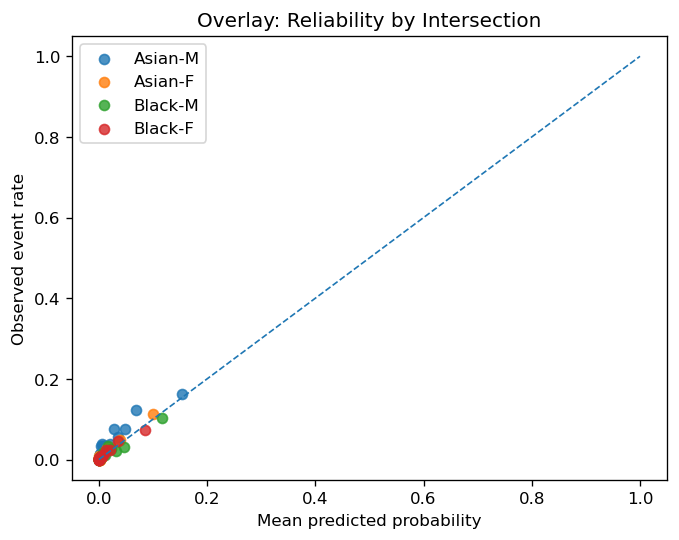

In [52]:
# Overlay reliability points for selected intersections on a single figure
def plot_group_overlay(df, pairs, prob_col="mortality_prob", y_col="died_within_30_days",
                       n_bins=20, strategy="quantile", title="Overlay: Reliability by Intersection"):
    plt.figure()
    plt.plot([0,1],[0,1],"--", linewidth=1)
    for (race, gender) in pairs:
        sub = df[(df["race_standard"]==race) & (df["gender"]==gender)]
        if len(sub) < 800: 
            continue
        yy = _ensure_binary(sub[y_col]); pp = _safe_prob(sub[prob_col])
        bins = summarize_bins(pp, yy, make_bins(pp, n_bins=n_bins, strategy=strategy))
        x = [b.p_mean for b in bins]; yb = [b.y_rate for b in bins]
        plt.scatter(x, yb, label=f"{race}-{gender}", alpha=0.8)
    plt.xlabel("Mean predicted probability"); plt.ylabel("Observed event rate")
    plt.title(title); plt.legend(); plt.show()

plot_group_overlay(df_clean, [("Asian","M"), ("Asian","F"), ("Black","M"), ("Black","F")])


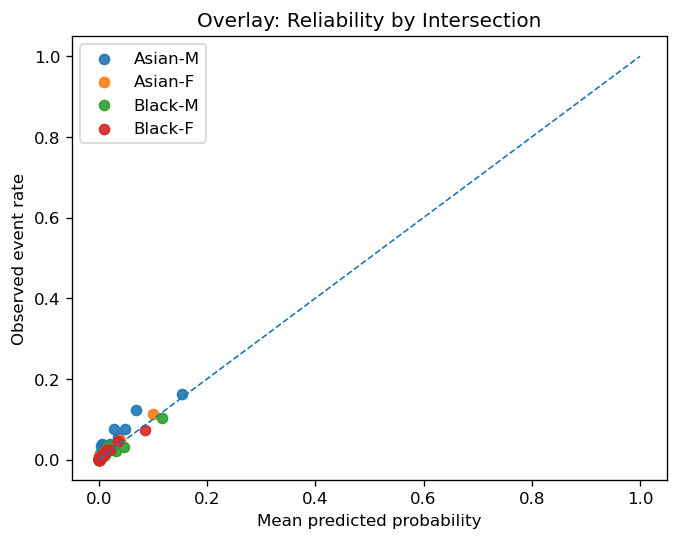

In [54]:
def plot_group_overlay_save(df, pairs, outpath,
                            prob_col="mortality_prob", y_col="died_within_30_days",
                            n_bins=20, strategy="quantile", title="Overlay: Reliability by Intersection"):
    plt.figure()
    plt.plot([0,1],[0,1],"--", linewidth=1)
    for (race, gender) in pairs:
        sub = df[(df["race_standard"]==race) & (df["gender"]==gender)]
        if len(sub) < 800: 
            continue
        yy = _ensure_binary(sub[y_col]); pp = _safe_prob(sub[prob_col])
        bins = summarize_bins(pp, yy, make_bins(pp, n_bins=n_bins, strategy=strategy))
        x = [b.p_mean for b in bins]; yb = [b.y_rate for b in bins]
        plt.scatter(x, yb, label=f"{race}-{gender}", alpha=0.9)
    plt.xlabel("Mean predicted probability"); plt.ylabel("Observed event rate")
    plt.title(title); plt.legend()
    os.makedirs(os.path.dirname(outpath), exist_ok=True)
    plt.savefig(outpath, bbox_inches="tight"); plt.show()

plot_group_overlay_save(
    df_clean,
    pairs=[("Asian","M"),("Asian","F"),("Black","M"),("Black","F")],
    outpath="dataset/ed/finals/pics/16_finalwithsigmoid_overlay_race_gender.png"
)


In [56]:
# quick disparity summary from your existing intersection report (rep_ix)
disp = {
    "ECE_range": (rep_ix["ECE"].min(), rep_ix["ECE"].max(), rep_ix["ECE"].max()-rep_ix["ECE"].min()),
    "ACE_range": (rep_ix["ACE"].min(), rep_ix["ACE"].max(), rep_ix["ACE"].max()-rep_ix["ACE"].min()),
    "Brier_range": (rep_ix["Brier"].min(), rep_ix["Brier"].max(), rep_ix["Brier"].max()-rep_ix["Brier"].min()),
    "MCE_max": rep_ix["MCE"].max()
}
disp


{'ECE_range': (0.0025837158869032786,
  0.01615875693699772,
  0.01357504105009444),
 'ACE_range': (0.0037968619111551564,
  0.022050435394325513,
  0.018253573483170357),
 'Brier_range': (0.0060384966994100515,
  0.03287611085887803,
  0.02683761415946798),
 'MCE_max': 0.05444756204209497}

In [58]:
# ===== Cell 11: Bootstrap CIs (overall, groups, intersections) =====
import numpy as np

def _metric_values(labels, probs, n_bins=20, strategy="quantile"):
    bins = summarize_bins(probs, labels, make_bins(probs, n_bins=n_bins, strategy=strategy))
    return {
        "ECE":  ece_from_bins(bins),
        "ACE":  rmsce_from_bins(bins),
        "Brier": brier_score(labels, probs)
    }

def _bootstrap_ci(labels, probs, n_bins=20, strategy="quantile",
                  B=200, alpha=0.05, rng=None):
    rng = np.random.default_rng(rng)
    base = _metric_values(labels, probs, n_bins, strategy)
    ece_s, ace_s, bs_s = [], [], []
    n = len(labels)
    idx = np.arange(n)
    for _ in range(B):
        samp = rng.choice(idx, size=n, replace=True)
        mv = _metric_values(labels[samp], probs[samp], n_bins, strategy)
        ece_s.append(mv["ECE"]); ace_s.append(mv["ACE"]); bs_s.append(mv["Brier"])
    def _ci(a):
        a = np.asarray(a)
        return float(np.nanquantile(a, alpha/2)), float(np.nanquantile(a, 1-alpha/2))
    return {
        "ECE":  base["ECE"],   "ECE_lo":  _ci(ece_s)[0], "ECE_hi":  _ci(ece_s)[1],
        "ACE":  base["ACE"],   "ACE_lo":  _ci(ace_s)[0], "ACE_hi":  _ci(ace_s)[1],
        "Brier":base["Brier"], "Brier_lo":_ci(bs_s)[0],  "Brier_hi":_ci(bs_s)[1]
    }

def bootstrap_overall_CI(df, prob_col="mortality_prob", y_col="died_within_30_days",
                         n_bins=20, B=200, alpha=0.05, seed=42):
    y = _ensure_binary(df[y_col]); p = _safe_prob(df[prob_col])
    res = _bootstrap_ci(y, p, n_bins=n_bins, strategy="quantile", B=B, alpha=alpha, rng=seed)
    out = pd.DataFrame([{**{"section":"overall","n":len(y),"prevalence":float(y.mean())}, **res}])
    out_path = os.path.join(BASE_OUT, f"{BASE_NAME}_bootstrap_overall.csv")
    out.to_csv(out_path, index=False); display(out); print("Saved:", out_path)
    return out

def bootstrap_by_group(df, group_col, prob_col="mortality_prob", y_col="died_within_30_days",
                       n_bins=20, B=200, alpha=0.05, seed=42, min_n=1000):
    rows=[]
    rng = np.random.default_rng(seed)
    for g, sub in df.groupby(group_col):
        if len(sub) < min_n: 
            print(f"[skip] {group_col}={g!r} n<{min_n}")
            continue
        y = _ensure_binary(sub[y_col]); p = _safe_prob(sub[prob_col])
        res = _bootstrap_ci(y, p, n_bins=n_bins, strategy="quantile", B=B, alpha=alpha, rng=rng)
        rows.append({group_col:g, "n":len(y), "prevalence":float(y.mean()), **res})
    if not rows:
        print("[INFO] no groups met min_n")
        return None
    out = pd.DataFrame(rows).sort_values("ECE")
    out_path = os.path.join(BASE_OUT, f"{BASE_NAME}_bootstrap_{group_col}.csv")
    out.to_csv(out_path, index=False); display(out.head(10)); print("Saved:", out_path)
    return out

def bootstrap_intersection(df, group_cols=("race_standard","gender"),
                           prob_col="mortality_prob", y_col="died_within_30_days",
                           n_bins=20, B=200, alpha=0.05, seed=42, min_n=800):
    g = df.copy()
    for c in group_cols:
        if c not in g.columns:
            print(f"[WARN] missing {c}; abort intersections"); return None
    g["_ix_"] = list(zip(*[g[c].astype(str).fillna("NA") for c in group_cols]))
    rows=[]; rng = np.random.default_rng(seed)
    for key, sub in g.groupby("_ix_"):
        if len(sub) < min_n: 
            continue
        y = _ensure_binary(sub[y_col]); p = _safe_prob(sub[prob_col])
        res = _bootstrap_ci(y, p, n_bins=n_bins, strategy="quantile", B=B, alpha=alpha, rng=rng)
        rows.append({"group": key, "n":len(y), "prevalence":float(y.mean()), **res})
    if not rows:
        print("[INFO] no intersections met min_n")
        return None
    out = pd.DataFrame(rows).sort_values("ECE")
    name = "x".join(group_cols)
    out_path = os.path.join(BASE_OUT, f"{BASE_NAME}_bootstrap_intersection_{name}.csv")
    out.to_csv(out_path, index=False); display(out.head(10)); print("Saved:", out_path)
    return out

# Run (B=200 by default; increase to 500 if you want tighter CIs)
boot_overall = bootstrap_overall_CI(df_clean, n_bins=20, B=200)
boot_race    = bootstrap_by_group(df_clean, "race_standard", n_bins=20, B=200)
boot_gender  = bootstrap_by_group(df_clean, "gender", n_bins=20, B=200)
boot_ix      = bootstrap_intersection(df_clean, ("race_standard","gender"), n_bins=20, B=200)


,section,n,prevalence,ECE,ECE_lo,ECE_hi,ACE,ACE_lo,ACE_hi,Brier,Brier_lo,Brier_hi
0,overall,232895,0.022212,0.005934,0.005373,0.00647,0.007409,0.006802,0.00828,0.020054,0.019527,0.020587


Saved: dataset/ed/finals/pics\16_finalwithsigmoid_bootstrap_overall.csv
[skip] race_standard='American Indian/Alaska Native' n<1000
[skip] race_standard='Multiple Races' n<1000
[skip] race_standard='Native Hawaiian/Pacific Islander' n<1000


,race_standard,n,prevalence,ECE,ECE_lo,ECE_hi,ACE,ACE_lo,ACE_hi,Brier,Brier_lo,Brier_hi
2,Hispanic/Latino,21868,0.008963,0.002343,0.001963,0.003853,0.003363,0.002916,0.006635,0.008248,0.007171,0.009295
1,Black,53687,0.012722,0.003281,0.002532,0.004381,0.004623,0.003552,0.006709,0.011858,0.011072,0.012701
4,White,131424,0.027316,0.007953,0.007091,0.008829,0.009617,0.008843,0.010895,0.024780,0.024010,0.025565
0,Asian,10453,0.023438,0.009011,0.006862,0.012445,0.012484,0.009732,0.018997,0.021194,0.018911,0.024172
3,Other/Unknown/Not Reported,14542,0.030257,0.009819,0.007880,0.012417,0.015806,0.012715,0.020987,0.024663,0.022500,0.026824


Saved: dataset/ed/finals/pics\16_finalwithsigmoid_bootstrap_race_standard.csv


,gender,n,prevalence,ECE,ECE_lo,ECE_hi,ACE,ACE_lo,ACE_hi,Brier,Brier_lo,Brier_hi
0,F,136433,0.018082,0.004864,0.004185,0.005640,0.006505,0.00566,0.007804,0.016417,0.015736,0.017085
1,M,96462,0.028052,0.007448,0.006736,0.008244,0.009119,0.00824,0.010322,0.025197,0.024370,0.025973


Saved: dataset/ed/finals/pics\16_finalwithsigmoid_bootstrap_gender.csv


,group,n,prevalence,ECE,ECE_lo,ECE_hi,ACE,ACE_lo,ACE_hi,Brier,Brier_lo,Brier_hi
4,"(Hispanic/Latino, F)",13985,0.006578,0.002783,0.002175,0.004089,0.004692,0.003582,0.007302,0.006038,0.004771,0.007237
2,"(Black, F)",35195,0.011365,0.003192,0.002433,0.004311,0.004789,0.003515,0.007096,0.010795,0.009765,0.011953
5,"(Hispanic/Latino, M)",7883,0.013193,0.004374,0.003700,0.007764,0.005649,0.005097,0.011114,0.012168,0.009929,0.014239
0,"(Asian, F)",6184,0.014554,0.004524,0.003299,0.007796,0.006291,0.004777,0.013520,0.013130,0.010393,0.015920
3,"(Black, M)",18492,0.015304,0.005016,0.004181,0.006862,0.007126,0.006152,0.010261,0.013882,0.012409,0.015586
8,"(White, F)",72092,0.023234,0.007002,0.005990,0.008081,0.008927,0.007885,0.010602,0.021047,0.020107,0.021943
9,"(White, M)",59332,0.032276,0.009111,0.007645,0.010566,0.010873,0.009443,0.012831,0.029317,0.027974,0.030502
6,"(Other/Unknown/Not Reported, F)",8469,0.024324,0.009721,0.007232,0.012542,0.018165,0.012448,0.025737,0.020563,0.018345,0.023329
7,"(Other/Unknown/Not Reported, M)",6073,0.038531,0.013245,0.009119,0.017062,0.019700,0.013865,0.028831,0.030380,0.026160,0.034239
1,"(Asian, M)",4269,0.036308,0.016231,0.011923,0.022259,0.022330,0.017524,0.034025,0.032876,0.027483,0.038175


Saved: dataset/ed/finals/pics\16_finalwithsigmoid_bootstrap_intersection_race_standardxgender.csv


In [59]:
# ===== Cell 12: Threshold audit at global percentiles =====
from typing import Sequence

def thresholds_from_percentiles(probs: np.ndarray, percentiles: Sequence[float]):
    qs = np.clip(np.asarray(percentiles), 0, 1)
    return dict(zip(qs, np.quantile(probs, qs)))

def confusion_from_threshold(y: np.ndarray, p: np.ndarray, thr: float):
    pred = (p >= thr).astype(int)
    TP = int(((pred==1) & (y==1)).sum())
    FP = int(((pred==1) & (y==0)).sum())
    FN = int(((pred==0) & (y==1)).sum())
    TN = int(((pred==0) & (y==0)).sum())
    return TP, FP, FN, TN

def rates_from_counts(TP, FP, FN, TN):
    P = TP+FN; N = TN+FP; D = P+N
    def safe(a,b): return float(a)/b if b>0 else np.nan
    return {
        "TPR": safe(TP, P),  # recall / sensitivity
        "FPR": safe(FP, N),
        "PPV": safe(TP, TP+FP),  # precision
        "NPV": safe(TN, TN+FN),
        "SelectionRate": safe(TP+FP, D),
        "Prevalence": safe(P, D)
    }

def threshold_audit(df, prob_col="mortality_prob", y_col="died_within_30_days",
                    group_cols=None, percentiles=(0.99, 0.95, 0.90), min_n=800):
    y_all = _ensure_binary(df[y_col]); p_all = _safe_prob(df[prob_col])
    thrs = thresholds_from_percentiles(p_all, percentiles)
    rows=[]

    # overall
    for q, thr in thrs.items():
        TP,FP,FN,TN = confusion_from_threshold(y_all, p_all, thr)
        rows.append({"level":"overall","group":None,"q":float(q),"thr":float(thr),
                     "n":len(y_all), **rates_from_counts(TP,FP,FN,TN)})

    # per-group or per-intersection
    if group_cols:
        gdf = df.copy()
        keycol = "_key_"
        if isinstance(group_cols, (list, tuple)) and len(group_cols)>1:
            gdf[keycol] = list(zip(*[gdf[c].astype(str).fillna("NA") for c in group_cols]))
        else:
            col = group_cols[0] if isinstance(group_cols, (list, tuple)) else group_cols
            gdf[keycol] = gdf[col].astype(str).fillna("NA")

        for key, sub in gdf.groupby(keycol):
            if len(sub) < min_n: 
                continue
            ys = _ensure_binary(sub[y_col]); ps = _safe_prob(sub[prob_col])
            for q, thr in thrs.items():
                TP,FP,FN,TN = confusion_from_threshold(ys, ps, thr)
                rows.append({"level":"group","group":key,"q":float(q),"thr":float(thr),
                             "n":len(ys), **rates_from_counts(TP,FP,FN,TN)})

    out = pd.DataFrame(rows)
    name = (group_cols if group_cols else "overall")
    if isinstance(name, (list, tuple)): name = "x".join(name)
    out_path = os.path.join(BASE_OUT, f"{BASE_NAME}_threshold_audit_{name}.csv")
    out.to_csv(out_path, index=False); display(out.head(12)); print("Saved:", out_path)
    return out

# Run: overall + by race, by gender, and intersection race×gender
ta_overall = threshold_audit(df_clean, group_cols=None)
ta_race    = threshold_audit(df_clean, group_cols="race_standard")
ta_gender  = threshold_audit(df_clean, group_cols="gender")
ta_ix      = threshold_audit(df_clean, group_cols=("race_standard","gender"))


,level,group,q,thr,n,TPR,FPR,PPV,NPV,SelectionRate,Prevalence
0,overall,None,0.99,0.149561,232895,0.127199,0.007382,0.281317,0.980417,0.010043,0.022212
1,overall,None,0.95,0.071415,232895,0.324763,0.043768,0.144243,0.984212,0.050010,0.022212
2,overall,None,0.90,0.045022,232895,0.477286,0.091678,0.105757,0.987096,0.100243,0.022212


Saved: dataset/ed/finals/pics\16_finalwithsigmoid_threshold_audit_overall.csv


,level,group,q,thr,n,TPR,FPR,PPV,NPV,SelectionRate,Prevalence
0,overall,None,0.99,0.149561,232895,0.127199,0.007382,0.281317,0.980417,0.010043,0.022212
1,overall,None,0.95,0.071415,232895,0.324763,0.043768,0.144243,0.984212,0.050010,0.022212
2,overall,None,0.90,0.045022,232895,0.477286,0.091678,0.105757,0.987096,0.100243,0.022212
3,group,Asian,0.99,0.149561,10453,0.097959,0.006955,0.252632,0.978664,0.009088,0.023438
4,group,Asian,0.95,0.071415,10453,0.297959,0.038989,0.154989,0.982769,0.045059,0.023438
5,group,Asian,0.90,0.045022,10453,0.469388,0.084052,0.118191,0.986287,0.093083,0.023438
6,group,Black,0.99,0.149561,53687,0.084919,0.003339,0.246809,0.988307,0.004377,0.012722
7,group,Black,0.95,0.071415,53687,0.224012,0.023394,0.109835,0.989865,0.025947,0.012722
8,group,Black,0.90,0.045022,53687,0.368960,0.056279,0.077898,0.991457,0.060257,0.012722
9,group,Hispanic/Latino,0.99,0.149561,21868,0.071429,0.001292,0.333333,0.991661,0.001921,0.008963


Saved: dataset/ed/finals/pics\16_finalwithsigmoid_threshold_audit_race_standard.csv


,level,group,q,thr,n,TPR,FPR,PPV,NPV,SelectionRate,Prevalence
0,overall,None,0.99,0.149561,232895,0.127199,0.007382,0.281317,0.980417,0.010043,0.022212
1,overall,None,0.95,0.071415,232895,0.324763,0.043768,0.144243,0.984212,0.050010,0.022212
2,overall,None,0.90,0.045022,232895,0.477286,0.091678,0.105757,0.987096,0.100243,0.022212
3,group,F,0.99,0.149561,136433,0.107418,0.004613,0.300113,0.983755,0.006472,0.018082
4,group,F,0.95,0.071415,136433,0.294285,0.035069,0.133850,0.986711,0.039756,0.018082
5,group,F,0.90,0.045022,136433,0.445075,0.074541,0.099062,0.989078,0.081241,0.018082
6,group,M,0.99,0.149561,96462,0.145233,0.011338,0.269918,0.975654,0.015094,0.028052
7,group,M,0.95,0.071415,96462,0.352550,0.056199,0.153302,0.980585,0.064512,0.028052
8,group,M,0.90,0.045022,96462,0.506652,0.116163,0.111809,0.984145,0.127117,0.028052


Saved: dataset/ed/finals/pics\16_finalwithsigmoid_threshold_audit_gender.csv


,level,group,q,thr,n,TPR,FPR,PPV,NPV,SelectionRate,Prevalence
0,overall,None,0.99,0.149561,232895,0.127199,0.007382,0.281317,0.980417,0.010043,0.022212
1,overall,None,0.95,0.071415,232895,0.324763,0.043768,0.144243,0.984212,0.050010,0.022212
2,overall,None,0.90,0.045022,232895,0.477286,0.091678,0.105757,0.987096,0.100243,0.022212
3,group,"(Asian, F)",0.99,0.149561,6184,0.088889,0.002790,0.320000,0.986686,0.004043,0.014554
4,group,"(Asian, F)",0.95,0.071415,6184,0.311111,0.025271,0.153846,0.989670,0.029431,0.014554
5,group,"(Asian, F)",0.90,0.045022,6184,0.433333,0.059239,0.097500,0.991183,0.064683,0.014554
6,group,"(Asian, M)",0.99,0.149561,4269,0.103226,0.013126,0.228571,0.966897,0.016397,0.036308
7,group,"(Asian, M)",0.95,0.071415,4269,0.290323,0.059310,0.155709,0.972362,0.067697,0.036308
8,group,"(Asian, M)",0.90,0.045022,4269,0.490323,0.120807,0.132635,0.978626,0.134223,0.036308
9,group,"(Black, F)",0.99,0.149561,35195,0.050000,0.002299,0.200000,0.989172,0.002841,0.011365


Saved: dataset/ed/finals/pics\16_finalwithsigmoid_threshold_audit_race_standardxgender.csv


In [60]:
# ===== Cell 13: What-if per-group isotonic (CV) =====
from sklearn.model_selection import KFold
from sklearn.isotonic import IsotonicRegression

def isotonic_cv_predict(y, p, n_splits=5, seed=42):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    out = np.empty_like(p, dtype=float)
    for tr, va in kf.split(p):
        ir = IsotonicRegression(out_of_bounds="clip")
        ir.fit(p[tr], y[tr])
        out[va] = ir.transform(p[va])
    # numerical guard
    return np.clip(out, EPS, 1-EPS)

def whatif_group_isotonic(df, group_col, prob_col="mortality_prob", y_col="died_within_30_days",
                          n_bins=20, n_splits=5, min_n=1000, seed=42):
    rows=[]
    for g, sub in df.groupby(group_col):
        if len(sub) < min_n:
            print(f"[skip] {group_col}={g!r} n<{min_n}")
            continue
        yy = _ensure_binary(sub[y_col]); pp = _safe_prob(sub[prob_col])

        # BEFORE
        bins_b = summarize_bins(pp, yy, make_bins(pp, n_bins=n_bins, strategy="quantile"))
        met_b = {"ECE": ece_from_bins(bins_b), "ACE": rmsce_from_bins(bins_b),
                 "Brier": brier_score(yy, pp)}

        # AFTER (CV isotonic)
        pp_cal = isotonic_cv_predict(yy, pp, n_splits=n_splits, seed=seed)
        bins_a = summarize_bins(pp_cal, yy, make_bins(pp_cal, n_bins=n_bins, strategy="quantile"))
        met_a = {"ECE": ece_from_bins(bins_a), "ACE": rmsce_from_bins(bins_a),
                 "Brier": brier_score(yy, pp_cal)}

        rows.append({
            group_col: g, "n": len(sub), "prev": float(yy.mean()),
            "ECE_before": met_b["ECE"], "ECE_after": met_a["ECE"], "ECE_delta": met_a["ECE"]-met_b["ECE"],
            "ACE_before": met_b["ACE"], "ACE_after": met_a["ACE"], "ACE_delta": met_a["ACE"]-met_b["ACE"],
            "Brier_before": met_b["Brier"], "Brier_after": met_a["Brier"], "Brier_delta": met_a["Brier"]-met_b["Brier"]
        })
    if not rows:
        print("[INFO] no groups met min_n")
        return None
    out = pd.DataFrame(rows).sort_values("ECE_after")
    out_path = os.path.join(BASE_OUT, f"{BASE_NAME}_whatif_isotonic_{group_col}.csv")
    out.to_csv(out_path, index=False); display(out); print("Saved:", out_path)
    return out

# Run: by race, by gender; (do age_group if present and big enough)
wi_race   = whatif_group_isotonic(df_clean, "race_standard", n_bins=20, n_splits=5)
wi_gender = whatif_group_isotonic(df_clean, "gender", n_bins=20, n_splits=5)
# Optional:
# wi_age    = whatif_group_isotonic(df_clean, "age_group", n_bins=20, n_splits=5, min_n=2000)


[skip] race_standard='American Indian/Alaska Native' n<1000
[skip] race_standard='Multiple Races' n<1000
[skip] race_standard='Native Hawaiian/Pacific Islander' n<1000


,race_standard,n,prev,ECE_before,ECE_after,ECE_delta,ACE_before,ACE_after,ACE_delta,Brier_before,Brier_after,Brier_delta
1,Black,53687,0.012722,0.003281,0.001006,-0.002275,0.004623,0.001457,-0.003166,0.011858,0.011835,-0.000023
4,White,131424,0.027316,0.007953,0.001173,-0.006780,0.009617,0.001735,-0.007882,0.024780,0.024674,-0.000107
2,Hispanic/Latino,21868,0.008963,0.002343,0.001653,-0.000690,0.003363,0.001994,-0.001369,0.008248,0.008236,-0.000012
3,Other/Unknown/Not Reported,14542,0.030257,0.009819,0.003575,-0.006244,0.015806,0.004542,-0.011264,0.024663,0.023932,-0.000731
0,Asian,10453,0.023438,0.009011,0.004922,-0.004090,0.012484,0.006988,-0.005496,0.021194,0.021168,-0.000027


Saved: dataset/ed/finals/pics\16_finalwithsigmoid_whatif_isotonic_race_standard.csv


,gender,n,prev,ECE_before,ECE_after,ECE_delta,ACE_before,ACE_after,ACE_delta,Brier_before,Brier_after,Brier_delta
0,F,136433,0.018082,0.004864,0.000748,-0.004116,0.006505,0.000982,-0.005523,0.016417,0.016376,-0.000041
1,M,96462,0.028052,0.007448,0.001198,-0.006250,0.009119,0.001673,-0.007446,0.025197,0.025080,-0.000116


Saved: dataset/ed/finals/pics\16_finalwithsigmoid_whatif_isotonic_gender.csv
